# Assignment 4_OPM 662
## 1. Formulate and solve the optimization problem
### 1, c & d) Deterministic case

In [1]:
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Problem Instance 1

##### Create the model instance

In [2]:
model_P1 = Model("SurgeryScheduling_P1")

##### Define all sets

In [3]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 2)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 1)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:G", nrows = 1, skiprows = 1)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.mean(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.mean(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.mean(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [4]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4]
['A', 'A', 'C', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'J'}
{'A': 5.024999999999999, 'B': 39.98499999999999, 'C': 23.69199999999999, 'D': 14.785000000000002, 'E': 46.807999999999964, 'F': 25.973999999999997, 'G': 31.765999999999984, 'H': 21.255, 'I': 137.20899999999995, 'J': 18.066}
{'A': 9.818999999999999, 'B': 81.46099999999997, 'C': 59.623999999999995, 'D': 34.571, 'E': 120.89999999999996, 'F': 47.758, 'G': 43.94, 'H': 39.92300000000001, 'I': 94.75100000000002, 'J': 19.513}
{'A': 4.098, 'B': 40.356, 'C': 43.70499999999997, 'D': 18.531999999999996, 'E': 47.463999999999984, 'F': 23.92, 'G': 23.581000000000003, 'H': 21.98, 'I': 66.51299999999999, 'J': 43.008}
1209.6
1048.8
806.4


##### Define the decision variables

In [5]:
X = model_P1.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_P1.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_P1.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_P1.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_P1.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_P1.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_P1.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_P1.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_P1.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_P1.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [6]:
#The earliest start time of a surgery incision
model_P1.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_P1.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_P1.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_P1.add_constraint(WT == SMS-model_P1.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_P1.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_P1.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_P1.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_P1.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_P1.add_constraints(VT[r] == ORMS[r]-model_P1.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_P1.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_P1.add_constraints(model_P1.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1)]

##### Define linear expression

In [7]:
J = model_P1.sum((O[r]/60)*co for r in rooms)+model_P1.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [8]:
model_P1.minimize(J)

##### Solve the model

In [9]:
model_P1.solve()

docplex.mp.solution.SolveSolution(obj=480.265,values={start_sur_1:102.25..

In [10]:
model_P1.solve_details
model_P1.report()
model_P1.print_information()
model_P1.print_solution()
model_P1.get_solve_status()

* model SurgeryScheduling_P1 solved with objective = 480.265
Model: SurgeryScheduling_P1
 - number of variables: 39
   - binary=24, integer=0, continuous=15
 - number of constraints: 77
   - linear=77
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 480.265
  start_sur_1=102.258
  start_sur_2=5.025
  start_sur_3=42.634
  start_sur_4=18.066
  surgeon_makespan=112.077
  surgeon_wait=8.277
  order_2_1=1
  order_2_3=1
  order_2_4=1
  order_3_1=1
  order_4_1=1
  order_4_3=1
  perform_1_2=1
  perform_2_1=1
  perform_3_1=1
  perform_4_2=1
  OR_makespan_1=145.963
  OR_makespan_2=116.175
  OR_vacant_2=16.646
  Or_unused_1=94.037
  Or_unused_2=123.825
  surgeon_begin=5.025


<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-11-788ac332b1ec>:166: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-11-788ac332b1ec>:174: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-11-788ac332b1ec>:182: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_P1.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


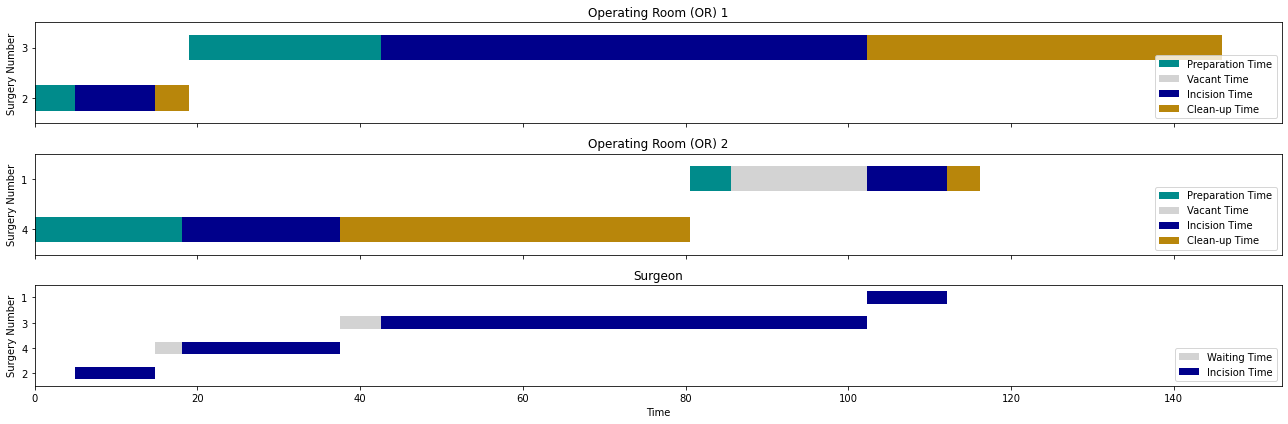

In [11]:
#Overiew of the surgery location
headers_sur_tab_P1 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_P1 = pd.DataFrame(columns = headers_sur_tab_P1)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_P1.loc[len(result_sur_tab_P1),headers_sur_tab_P1[h]] = s
    s+=1
    h+=1
    result_sur_tab_P1.loc[len(result_sur_tab_P1)-1,headers_sur_tab_P1[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_P1.loc[len(result_sur_tab_P1)-1,headers_sur_tab_P1[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_P1 = result_sur_tab_P1.loc[result_sur_tab_P1["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_P1["Surgery Number"].tolist()):
    result_OR1_tab_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_P1["Surgery Number"].tolist():
    result_OR1_tab_P1["Order"] = result_OR1_tab_P1["Beginning of Incision Time"].rank()
result_OR1_tab_P1.sort_values(by="Order", inplace = True)
result_OR1_tab_P1.reset_index(drop = True, inplace = True)
result_OR1_tab_P1.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_P1["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_P1)-1:
        result_OR1_tab_P1.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_P1["Surgery Number"].tolist()):
    result_OR1_tab_P1.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_P1.loc[idx,"End of Preparation Time"] = result_OR1_tab_P1.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_P1.loc[idx,"Preparation Time"]
    result_OR1_tab_P1.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_P1.loc[idx,"End of Preparation Time"]
    result_OR1_tab_P1.loc[idx,"Vacant Time"] = round(result_OR1_tab_P1.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_P1.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_P1.loc[idx,"End of Vacant Time"] = result_OR1_tab_P1.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_P1.loc[idx,"Vacant Time"]
    result_OR1_tab_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_P1.loc[idx,"End of Incision Time"] = result_OR1_tab_P1.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_P1.loc[idx,"Incision Time"]
    result_OR1_tab_P1.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_P1.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_P1.loc[idx,"End of Clean-up Time"] = result_OR1_tab_P1.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_P1.loc[idx,"Clean-up Time"]
result_OR1_tab_P1 = result_OR1_tab_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_P1["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_P1.loc[len(result_OR1_tab_P1)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_P1["Maximum Normal Shift Time"] = ""
result_OR1_tab_P1.loc[len(result_OR1_tab_P1)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_P1["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_P1.loc[len(result_OR1_tab_P1)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_P1 = result_OR1_tab_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_P1 = result_sur_tab_P1.loc[result_sur_tab_P1["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_P1["Surgery Number"].tolist()):
    result_OR2_tab_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_P1["Surgery Number"].tolist():
    result_OR2_tab_P1["Order"] = result_OR2_tab_P1["Beginning of Incision Time"].rank()
result_OR2_tab_P1.sort_values(by="Order", inplace = True)
result_OR2_tab_P1.reset_index(drop = True, inplace = True)
result_OR2_tab_P1.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_P1["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_P1)-1:
        result_OR2_tab_P1.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_P1["Surgery Number"].tolist()):
    result_OR2_tab_P1.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_P1.loc[idx,"End of Preparation Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_P1.loc[idx,"Preparation Time"]
    result_OR2_tab_P1.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_P1.loc[idx,"End of Preparation Time"]
    result_OR2_tab_P1.loc[idx,"Vacant Time"] = round(result_OR2_tab_P1.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_P1.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_P1.loc[idx,"End of Vacant Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_P1.loc[idx,"Vacant Time"]
    result_OR2_tab_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_P1.loc[idx,"End of Incision Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_P1.loc[idx,"Incision Time"]
    result_OR2_tab_P1.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_P1.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_P1.loc[idx,"End of Clean-up Time"] = result_OR2_tab_P1.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_P1.loc[idx,"Clean-up Time"]
result_OR2_tab_P1["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_P1.loc[len(result_OR2_tab_P1)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_P1["Maximum Normal Shift Time"] = ""
result_OR2_tab_P1.loc[len(result_OR2_tab_P1)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_P1["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_P1.loc[len(result_OR2_tab_P1)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_P1 = result_OR2_tab_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_P1 = result_sur_tab_P1.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_P1["Surgery Number"].tolist()):
    result_surgeons_tab_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_P1["Surgery Number"].tolist():
    result_surgeons_tab_P1["Order"] = result_surgeons_tab_P1["Beginning of Incision Time"].rank()
result_surgeons_tab_P1.sort_values(by="Order", inplace = True)
result_surgeons_tab_P1.reset_index(drop = True, inplace = True)
result_surgeons_tab_P1["Start Time of Surgeon"] = 0
result_surgeons_tab_P1.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_P1.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P1["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P1)-1:
        result_surgeons_tab_P1.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_P1.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P1["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P1)-1:
        result_surgeons_tab_P1.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_P1.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_P1.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_P1["Surgery Number"].tolist()):
    result_surgeons_tab_P1.loc[idx,"End of Waiting Time"] = result_surgeons_tab_P1.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_P1.loc[idx,"Waiting Time"]
    result_surgeons_tab_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_P1.loc[idx,"End of Incision Time"] = result_surgeons_tab_P1.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_P1.loc[idx,"Incision Time"]
result_surgeons_tab_P1 = result_surgeons_tab_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_P1 = result_sur_tab_P1.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_P1 = result_OR1_tab_P1.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_P1 = result_OR2_tab_P1.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_P1 = result_surgeons_tab_P1.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_P1 = headers_cost_tab_P3 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_P1 = pd.DataFrame(columns = headers_cost_tab_P1)
h=0
result_cost_tab_P1.loc[len(result_cost_tab_P1), headers_cost_tab_P1[h]] = O[1].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = O[2].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = co/60
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = VT[1].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = VT[2].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = cv/60
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = WT.solution_value
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = cw/60
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, headers_cost_tab_P1[h]] = result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, "Total OR Vacant Time Cost"]+result_cost_tab_P1.loc[len(result_cost_tab_P1)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_P1, (result_OR1_plot_P1, result_OR2_plot_P1, result_surgeons_plot_P1) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_P1 = result_OR1_tab_P1.plot.barh(ax = result_OR1_plot_P1, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_P1.set_xlabel("Time")
result_OR1_plot_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_P1 = result_OR2_tab_P1.plot.barh(ax = result_OR2_plot_P1, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_P1.set_xlabel("Time")
result_OR2_plot_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_P1 = result_surgeons_tab_P1.plot.barh(ax = result_surgeons_plot_P1, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_P1.set_xlabel("Time")
result_surgeons_plot_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_P1.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [12]:
print(result_sur_tab_P1)
print(result_OR1_tab_P1)
print(result_OR2_tab_P1)
print(result_surgeons_tab_P1)
print(result_cost_tab_P1)

               Surgery Type Location
Surgery Number                      
1                         A     OR 2
2                         A     OR 1
3                         C     OR 1
4                         J     OR 2
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
2                                A    1.0                          0.000   
3                                C    2.0                         18.942   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
2                                 5.025                    5.025   
3                                23.692                   42.634   

                       Beginning of Vacant Time  Vacant Time  \
Surgery Number | OR 1                                          
2                                         5.025          0.0   
3       

##### Export the results

In [13]:
with pd.ExcelWriter("SurgeryScheduling_Mean_P1.xlsx") as writer:
    result_sur_tab_P1.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_P1.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_P1.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_P1.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_P1.to_excel(writer, sheet_name = "Cost")   

In [14]:
figure_P1.savefig("Timeline_Mean_P1.pdf", bbox_inches="tight")
figure_P1.savefig("Timeline_Mean_P1.png", bbox_inches="tight")

#### Problem Instance 2

##### Create the model instance

In [15]:
model_P2 = Model("SurgeryScheduling_P2")

##### Define all sets

In [16]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 3)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 2)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:H", nrows = 1, skiprows = 2)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.mean(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.mean(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.mean(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [17]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4, 5]
['A', 'D', 'G', 'G', 'J']
{1: 'A', 2: 'D', 3: 'G', 4: 'G', 5: 'J'}
{'A': 5.024999999999999, 'B': 39.98499999999999, 'C': 23.69199999999999, 'D': 14.785000000000002, 'E': 46.807999999999964, 'F': 25.973999999999997, 'G': 31.765999999999984, 'H': 21.255, 'I': 137.20899999999995, 'J': 18.066}
{'A': 9.818999999999999, 'B': 81.46099999999997, 'C': 59.623999999999995, 'D': 34.571, 'E': 120.89999999999996, 'F': 47.758, 'G': 43.94, 'H': 39.92300000000001, 'I': 94.75100000000002, 'J': 19.513}
{'A': 4.098, 'B': 40.356, 'C': 43.70499999999997, 'D': 18.531999999999996, 'E': 47.463999999999984, 'F': 23.92, 'G': 23.581000000000003, 'H': 21.98, 'I': 66.51299999999999, 'J': 43.008}
1209.6
1048.8
806.4


##### Define the decision variables

In [18]:
X = model_P2.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_P2.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_P2.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_P2.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_P2.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_P2.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_P2.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_P2.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_P2.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_P2.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [19]:
#The earliest start time of a surgery incision
model_P2.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_P2.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_P2.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_P2.add_constraint(WT == SMS-model_P2.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_P2.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_P2.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_P2.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_P2.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_P2.add_constraints(VT[r] == ORMS[r]-model_P2.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_P2.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_P2.add_constraints(model_P2.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1)]

##### Define linear expression

In [20]:
J = model_P2.sum((O[r]/60)*co for r in rooms)+model_P2.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [21]:
model_P2.minimize(J)

##### Solve the model

In [22]:
model_P2.solve()

docplex.mp.solution.SolveSolution(obj=260.665,values={start_sur_1:5.025,..

In [23]:
model_P2.solve_details
model_P2.report()
model_P2.print_information()
model_P2.print_solution()
model_P2.get_solve_status()

* model SurgeryScheduling_P2 solved with objective = 260.665
Model: SurgeryScheduling_P2
 - number of variables: 51
   - binary=35, integer=0, continuous=16
 - number of constraints: 115
   - linear=115
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 260.665
  start_sur_1=5.025
  start_sur_2=14.844
  start_sur_3=99.713
  start_sur_4=55.773
  start_sur_5=143.653
  surgeon_makespan=163.166
  surgeon_wait=6.358
  order_1_2=1
  order_1_3=1
  order_1_4=1
  order_1_5=1
  order_2_3=1
  order_2_4=1
  order_2_5=1
  order_3_5=1
  order_4_3=1
  order_4_5=1
  perform_1_1=1
  perform_2_2=1
  perform_3_2=1
  perform_4_1=1
  perform_5_1=1
  OR_makespan_1=206.174
  OR_makespan_2=167.234
  OR_vacant_1=7.358
  OR_vacant_2=0.059
  Or_unused_1=33.826
  Or_unused_2=72.766
  surgeon_begin=5.025


<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-24-d9785951eb55>:166: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-24-d9785951eb55>:174: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-24-d9785951eb55>:182: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_P2.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


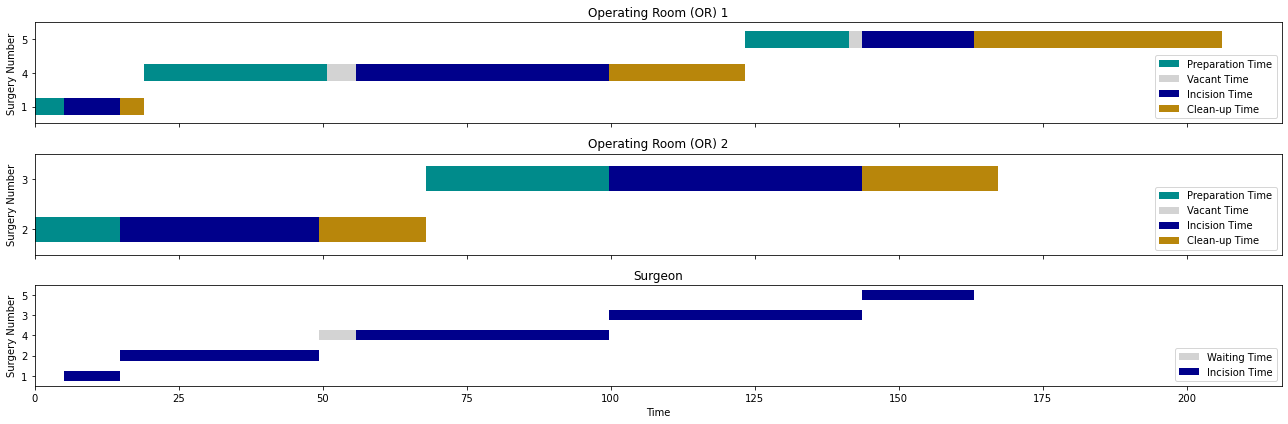

In [24]:
#Overiew of the surgery location
headers_sur_tab_P2 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_P2 = pd.DataFrame(columns = headers_sur_tab_P2)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_P2.loc[len(result_sur_tab_P2),headers_sur_tab_P2[h]] = s
    s+=1
    h+=1
    result_sur_tab_P2.loc[len(result_sur_tab_P2)-1,headers_sur_tab_P2[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_P2.loc[len(result_sur_tab_P2)-1,headers_sur_tab_P2[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_P2 = result_sur_tab_P2.loc[result_sur_tab_P2["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_P2["Surgery Number"].tolist()):
    result_OR1_tab_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_P2["Surgery Number"].tolist():
    result_OR1_tab_P2["Order"] = result_OR1_tab_P2["Beginning of Incision Time"].rank()
result_OR1_tab_P2.sort_values(by="Order", inplace = True)
result_OR1_tab_P2.reset_index(drop = True, inplace = True)
result_OR1_tab_P2.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_P2["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_P2)-1:
        result_OR1_tab_P2.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_P2["Surgery Number"].tolist()):
    result_OR1_tab_P2.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_P2.loc[idx,"End of Preparation Time"] = result_OR1_tab_P2.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_P2.loc[idx,"Preparation Time"]
    result_OR1_tab_P2.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_P2.loc[idx,"End of Preparation Time"]
    result_OR1_tab_P2.loc[idx,"Vacant Time"] = round(result_OR1_tab_P2.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_P2.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_P2.loc[idx,"End of Vacant Time"] = result_OR1_tab_P2.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_P2.loc[idx,"Vacant Time"]
    result_OR1_tab_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_P2.loc[idx,"End of Incision Time"] = result_OR1_tab_P2.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_P2.loc[idx,"Incision Time"]
    result_OR1_tab_P2.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_P2.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_P2.loc[idx,"End of Clean-up Time"] = result_OR1_tab_P2.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_P2.loc[idx,"Clean-up Time"]
result_OR1_tab_P2 = result_OR1_tab_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_P2["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_P2.loc[len(result_OR1_tab_P2)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_P2["Maximum Normal Shift Time"] = ""
result_OR1_tab_P2.loc[len(result_OR1_tab_P2)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_P2["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_P2.loc[len(result_OR1_tab_P2)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_P2 = result_OR1_tab_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_P2 = result_sur_tab_P2.loc[result_sur_tab_P2["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_P2["Surgery Number"].tolist()):
    result_OR2_tab_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_P2["Surgery Number"].tolist():
    result_OR2_tab_P2["Order"] = result_OR2_tab_P2["Beginning of Incision Time"].rank()
result_OR2_tab_P2.sort_values(by="Order", inplace = True)
result_OR2_tab_P2.reset_index(drop = True, inplace = True)
result_OR2_tab_P2.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_P2["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_P2)-1:
        result_OR2_tab_P2.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_P2["Surgery Number"].tolist()):
    result_OR2_tab_P2.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_P2.loc[idx,"End of Preparation Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_P2.loc[idx,"Preparation Time"]
    result_OR2_tab_P2.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_P2.loc[idx,"End of Preparation Time"]
    result_OR2_tab_P2.loc[idx,"Vacant Time"] = round(result_OR2_tab_P2.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_P2.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_P2.loc[idx,"End of Vacant Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_P2.loc[idx,"Vacant Time"]
    result_OR2_tab_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_P2.loc[idx,"End of Incision Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_P2.loc[idx,"Incision Time"]
    result_OR2_tab_P2.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_P2.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_P2.loc[idx,"End of Clean-up Time"] = result_OR2_tab_P2.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_P2.loc[idx,"Clean-up Time"]
result_OR2_tab_P2["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_P2.loc[len(result_OR2_tab_P2)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_P2["Maximum Normal Shift Time"] = ""
result_OR2_tab_P2.loc[len(result_OR2_tab_P2)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_P2["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_P2.loc[len(result_OR2_tab_P2)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_P2 = result_OR2_tab_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_P2 = result_sur_tab_P2.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_P2["Surgery Number"].tolist()):
    result_surgeons_tab_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_P2["Surgery Number"].tolist():
    result_surgeons_tab_P2["Order"] = result_surgeons_tab_P2["Beginning of Incision Time"].rank()
result_surgeons_tab_P2.sort_values(by="Order", inplace = True)
result_surgeons_tab_P2.reset_index(drop = True, inplace = True)
result_surgeons_tab_P2["Start Time of Surgeon"] = 0
result_surgeons_tab_P2.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_P2.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P2["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P2)-1:
        result_surgeons_tab_P2.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_P2.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P2["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P2)-1:
        result_surgeons_tab_P2.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_P2.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_P2.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_P2["Surgery Number"].tolist()):
    result_surgeons_tab_P2.loc[idx,"End of Waiting Time"] = result_surgeons_tab_P2.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_P2.loc[idx,"Waiting Time"]
    result_surgeons_tab_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_P2.loc[idx,"End of Incision Time"] = result_surgeons_tab_P2.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_P2.loc[idx,"Incision Time"]
result_surgeons_tab_P2 = result_surgeons_tab_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_P2 = result_sur_tab_P2.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_P2 = result_OR1_tab_P2.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_P2 = result_OR2_tab_P2.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_P2 = result_surgeons_tab_P2.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_P2 = headers_cost_tab_P3 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_P2 = pd.DataFrame(columns = headers_cost_tab_P2)
h=0
result_cost_tab_P2.loc[len(result_cost_tab_P2), headers_cost_tab_P2[h]] = O[1].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = O[2].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = co/60
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = VT[1].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = VT[2].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = cv/60
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = WT.solution_value
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = cw/60
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, headers_cost_tab_P2[h]] = result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, "Total OR Vacant Time Cost"]+result_cost_tab_P2.loc[len(result_cost_tab_P2)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_P2, (result_OR1_plot_P2, result_OR2_plot_P2, result_surgeons_plot_P2) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_P2 = result_OR1_tab_P2.plot.barh(ax = result_OR1_plot_P2, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_P2.set_xlabel("Time")
result_OR1_plot_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_P2 = result_OR2_tab_P2.plot.barh(ax = result_OR2_plot_P2, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_P2.set_xlabel("Time")
result_OR2_plot_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_P2 = result_surgeons_tab_P2.plot.barh(ax = result_surgeons_plot_P2, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_P2.set_xlabel("Time")
result_surgeons_plot_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_P2.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [25]:
print(result_sur_tab_P2)
print(result_OR1_tab_P2)
print(result_OR2_tab_P2)
print(result_surgeons_tab_P2)
print(result_cost_tab_P2)

               Surgery Type Location
Surgery Number                      
1                         A     OR 1
2                         D     OR 2
3                         G     OR 2
4                         G     OR 1
5                         J     OR 1
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
1                                A    1.0                          0.000   
4                                G    2.0                         18.942   
5                                J    3.0                        123.294   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
1                                 5.025                    5.025   
4                                31.766                   50.708   
5                                18.066                  141.360   

                   

##### Export the results

In [26]:
with pd.ExcelWriter("SurgeryScheduling_Mean_P2.xlsx") as writer:
    result_sur_tab_P2.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_P2.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_P2.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_P2.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_P2.to_excel(writer, sheet_name = "Cost")   

In [27]:
figure_P2.savefig("Timeline_Mean_P2.pdf", bbox_inches="tight")
figure_P2.savefig("Timeline_Mean_P2.png", bbox_inches="tight")

#### Problem Instance 3

##### Create the model instance

In [28]:
model_P3 = Model("SurgeryScheduling_P3")

##### Define all sets

In [29]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 4)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 3)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:J", nrows = 1, skiprows = 3)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.mean(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.mean(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.mean(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [30]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
480
[1, 2, 3, 4, 5, 6, 7]
['A', 'B', 'D', 'E', 'G', 'G', 'J']
{1: 'A', 2: 'B', 3: 'D', 4: 'E', 5: 'G', 6: 'G', 7: 'J'}
{'A': 5.024999999999999, 'B': 39.98499999999999, 'C': 23.69199999999999, 'D': 14.785000000000002, 'E': 46.807999999999964, 'F': 25.973999999999997, 'G': 31.765999999999984, 'H': 21.255, 'I': 137.20899999999995, 'J': 18.066}
{'A': 9.818999999999999, 'B': 81.46099999999997, 'C': 59.623999999999995, 'D': 34.571, 'E': 120.89999999999996, 'F': 47.758, 'G': 43.94, 'H': 39.92300000000001, 'I': 94.75100000000002, 'J': 19.513}
{'A': 4.098, 'B': 40.356, 'C': 43.70499999999997, 'D': 18.531999999999996, 'E': 47.463999999999984, 'F': 23.92, 'G': 23.581000000000003, 'H': 21.98, 'I': 66.51299999999999, 'J': 43.008}
1209.6
1048.8
806.4


##### Define the decision variables

In [31]:
X = model_P3.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_P3.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_P3.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_P3.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_P3.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_P3.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_P3.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_P3.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_P3.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_P3.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [32]:
#The earliest start time of a surgery incision
model_P3.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_P3.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_P3.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_P3.add_constraint(WT == SMS-model_P3.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_P3.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_P3.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_P3.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_P3.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_P3.add_constraints(VT[r] == ORMS[r]-model_P3.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_P3.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_P3.add_constraints(model_P3.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1)]

##### Define linear expression

In [33]:
J = model_P3.sum((O[r]/60)*co for r in rooms)+model_P3.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [34]:
model_P3.minimize(J)

##### Solve the model

In [35]:
model_P3.solve()

docplex.mp.solution.SolveSolution(obj=982.567,values={start_sur_1:5.025,..

In [36]:
model_P3.solve_details
model_P3.report()
model_P3.print_information()
model_P3.print_solution()
model_P3.get_solve_status()

* model SurgeryScheduling_P3 solved with objective = 982.567
Model: SurgeryScheduling_P3
 - number of variables: 81
   - binary=63, integer=0, continuous=18
 - number of constraints: 215
   - linear=215
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 982.567
  start_sur_1=5.025
  start_sur_2=193.935
  start_sur_3=95.372
  start_sur_4=275.396
  start_sur_5=50.708
  start_sur_6=149.995
  start_sur_7=18.066
  surgeon_makespan=396.296
  surgeon_wait=37.127
  order_1_2=1
  order_1_3=1
  order_1_4=1
  order_1_5=1
  order_1_6=1
  order_1_7=1
  order_2_4=1
  order_3_2=1
  order_3_4=1
  order_3_6=1
  order_5_2=1
  order_5_3=1
  order_5_4=1
  order_5_6=1
  order_6_2=1
  order_6_4=1
  order_7_2=1
  order_7_3=1
  order_7_4=1
  order_7_5=1
  order_7_6=1
  perform_1_2=1
  perform_2_1=1
  perform_3_1=1
  perform_4_2=1
  perform_5_2=1
  perform_6_2=1
  perform_7_1=1
  OR_makespan_1=315.752
  OR_makespan_2=443.760
  OR_vacant_1=5.475
  OR_vacant_2=11.072
  Or_unused_1

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-37-54b2fecfa6e9>:166: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-37-54b2fecfa6e9>:174: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-37-54b2fecfa6e9>:182: UserWarning: The handle <BarContainer object of 7 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_P3.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


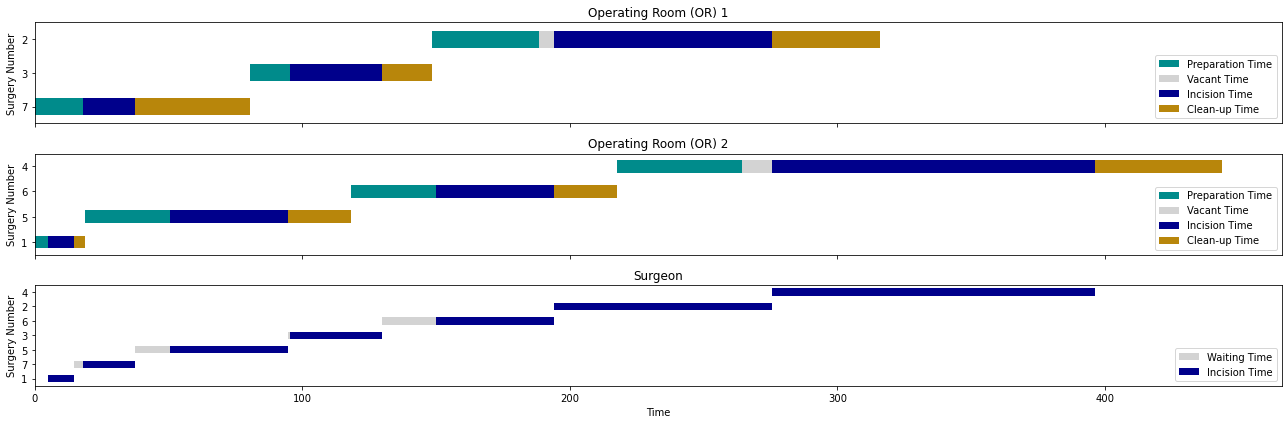

In [37]:
#Overiew of the surgery location
headers_sur_tab_P3 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_P3 = pd.DataFrame(columns = headers_sur_tab_P3)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_P3.loc[len(result_sur_tab_P3),headers_sur_tab_P3[h]] = s
    s+=1
    h+=1
    result_sur_tab_P3.loc[len(result_sur_tab_P3)-1,headers_sur_tab_P3[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_P3.loc[len(result_sur_tab_P3)-1,headers_sur_tab_P3[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_P3 = result_sur_tab_P3.loc[result_sur_tab_P3["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_P3["Surgery Number"].tolist()):
    result_OR1_tab_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_P3["Surgery Number"].tolist():
    result_OR1_tab_P3["Order"] = result_OR1_tab_P3["Beginning of Incision Time"].rank()
result_OR1_tab_P3.sort_values(by="Order", inplace = True)
result_OR1_tab_P3.reset_index(drop = True, inplace = True)
result_OR1_tab_P3.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_P3["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_P3)-1:
        result_OR1_tab_P3.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_P3["Surgery Number"].tolist()):
    result_OR1_tab_P3.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_P3.loc[idx,"End of Preparation Time"] = result_OR1_tab_P3.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_P3.loc[idx,"Preparation Time"]
    result_OR1_tab_P3.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_P3.loc[idx,"End of Preparation Time"]
    result_OR1_tab_P3.loc[idx,"Vacant Time"] = round(result_OR1_tab_P3.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_P3.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_P3.loc[idx,"End of Vacant Time"] = result_OR1_tab_P3.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_P3.loc[idx,"Vacant Time"]
    result_OR1_tab_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_P3.loc[idx,"End of Incision Time"] = result_OR1_tab_P3.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_P3.loc[idx,"Incision Time"]
    result_OR1_tab_P3.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_P3.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_P3.loc[idx,"End of Clean-up Time"] = result_OR1_tab_P3.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_P3.loc[idx,"Clean-up Time"]
result_OR1_tab_P3 = result_OR1_tab_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_P3["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_P3.loc[len(result_OR1_tab_P3)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_P3["Maximum Normal Shift Time"] = ""
result_OR1_tab_P3.loc[len(result_OR1_tab_P3)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_P3["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_P3.loc[len(result_OR1_tab_P3)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_P3 = result_OR1_tab_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_P3 = result_sur_tab_P3.loc[result_sur_tab_P3["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_P3["Surgery Number"].tolist()):
    result_OR2_tab_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_P3["Surgery Number"].tolist():
    result_OR2_tab_P3["Order"] = result_OR2_tab_P3["Beginning of Incision Time"].rank()
result_OR2_tab_P3.sort_values(by="Order", inplace = True)
result_OR2_tab_P3.reset_index(drop = True, inplace = True)
result_OR2_tab_P3.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_P3["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_P3)-1:
        result_OR2_tab_P3.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_P3["Surgery Number"].tolist()):
    result_OR2_tab_P3.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_P3.loc[idx,"End of Preparation Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_P3.loc[idx,"Preparation Time"]
    result_OR2_tab_P3.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_P3.loc[idx,"End of Preparation Time"]
    result_OR2_tab_P3.loc[idx,"Vacant Time"] = round(result_OR2_tab_P3.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_P3.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_P3.loc[idx,"End of Vacant Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_P3.loc[idx,"Vacant Time"]
    result_OR2_tab_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_P3.loc[idx,"End of Incision Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_P3.loc[idx,"Incision Time"]
    result_OR2_tab_P3.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_P3.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_P3.loc[idx,"End of Clean-up Time"] = result_OR2_tab_P3.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_P3.loc[idx,"Clean-up Time"]
result_OR2_tab_P3["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_P3.loc[len(result_OR2_tab_P3)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_P3["Maximum Normal Shift Time"] = ""
result_OR2_tab_P3.loc[len(result_OR2_tab_P3)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_P3["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_P3.loc[len(result_OR2_tab_P3)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_P3 = result_OR2_tab_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_P3 = result_sur_tab_P3.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_P3["Surgery Number"].tolist()):
    result_surgeons_tab_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_P3["Surgery Number"].tolist():
    result_surgeons_tab_P3["Order"] = result_surgeons_tab_P3["Beginning of Incision Time"].rank()
result_surgeons_tab_P3.sort_values(by="Order", inplace = True)
result_surgeons_tab_P3.reset_index(drop = True, inplace = True)
result_surgeons_tab_P3["Start Time of Surgeon"] = 0
result_surgeons_tab_P3.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_P3.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P3["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P3)-1:
        result_surgeons_tab_P3.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_P3.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P3["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P3)-1:
        result_surgeons_tab_P3.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_P3.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_P3.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_P3["Surgery Number"].tolist()):
    result_surgeons_tab_P3.loc[idx,"End of Waiting Time"] = result_surgeons_tab_P3.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_P3.loc[idx,"Waiting Time"]
    result_surgeons_tab_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_P3.loc[idx,"End of Incision Time"] = result_surgeons_tab_P3.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_P3.loc[idx,"Incision Time"]
result_surgeons_tab_P3 = result_surgeons_tab_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_P3 = result_sur_tab_P3.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_P3 = result_OR1_tab_P3.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_P3 = result_OR2_tab_P3.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_P3 = result_surgeons_tab_P3.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_P3 = headers_cost_tab_P3 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_P3 = pd.DataFrame(columns = headers_cost_tab_P3)
h=0
result_cost_tab_P3.loc[len(result_cost_tab_P3), headers_cost_tab_P3[h]] = O[1].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = O[2].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = co/60
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = VT[1].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = VT[2].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = cv/60
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = WT.solution_value
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = cw/60
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, headers_cost_tab_P3[h]] = result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, "Total OR Vacant Time Cost"]+result_cost_tab_P3.loc[len(result_cost_tab_P3)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_P3, (result_OR1_plot_P3, result_OR2_plot_P3, result_surgeons_plot_P3) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_P3 = result_OR1_tab_P3.plot.barh(ax = result_OR1_plot_P3, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_P3.set_xlabel("Time")
result_OR1_plot_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_P3 = result_OR2_tab_P3.plot.barh(ax = result_OR2_plot_P3, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_P3.set_xlabel("Time")
result_OR2_plot_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_P3 = result_surgeons_tab_P3.plot.barh(ax = result_surgeons_plot_P3, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_P3.set_xlabel("Time")
result_surgeons_plot_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_P3.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [38]:
print(result_sur_tab_P3)
print(result_OR1_tab_P3)
print(result_OR2_tab_P3)
print(result_surgeons_tab_P3)
print(result_cost_tab_P3)

               Surgery Type Location
Surgery Number                      
1                         A     OR 2
2                         B     OR 1
3                         D     OR 1
4                         E     OR 2
5                         G     OR 2
6                         G     OR 2
7                         J     OR 1
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
7                                J    1.0                          0.000   
3                                D    2.0                         80.587   
2                                B    3.0                        148.475   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
7                                18.066                   18.066   
3                                14.785                   95.372   
2             

##### Export the results

In [39]:
with pd.ExcelWriter("SurgeryScheduling_Mean_P3.xlsx") as writer:
    result_sur_tab_P3.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_P3.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_P3.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_P3.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_P3.to_excel(writer, sheet_name = "Cost")   

In [40]:
figure_P3.savefig("Timeline_Mean_P3.pdf", bbox_inches="tight")
figure_P3.savefig("Timeline_Mean_P3.png", bbox_inches="tight")

#### Problem Instance 4

##### Create the model instance

In [41]:
model_P4 = Model("SurgeryScheduling_P4")

##### Define all sets

In [42]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 5)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 4)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:N", nrows = 1, skiprows = 4)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.mean(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.mean(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.mean(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [43]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
720
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['A', 'A', 'C', 'E', 'E', 'F', 'G', 'H', 'I', 'I', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'E', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'I', 11: 'J'}
{'A': 5.024999999999999, 'B': 39.98499999999999, 'C': 23.69199999999999, 'D': 14.785000000000002, 'E': 46.807999999999964, 'F': 25.973999999999997, 'G': 31.765999999999984, 'H': 21.255, 'I': 137.20899999999995, 'J': 18.066}
{'A': 9.818999999999999, 'B': 81.46099999999997, 'C': 59.623999999999995, 'D': 34.571, 'E': 120.89999999999996, 'F': 47.758, 'G': 43.94, 'H': 39.92300000000001, 'I': 94.75100000000002, 'J': 19.513}
{'A': 4.098, 'B': 40.356, 'C': 43.70499999999997, 'D': 18.531999999999996, 'E': 47.463999999999984, 'F': 23.92, 'G': 23.581000000000003, 'H': 21.98, 'I': 66.51299999999999, 'J': 43.008}
1209.6
1048.8
806.4


##### Define the decision variables

In [44]:
X = model_P4.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_P4.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_P4.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_P4.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_P4.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_P4.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_P4.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_P4.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_P4.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_P4.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [45]:
#The earliest start time of a surgery incision
model_P4.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_P4.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_P4.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_P4.add_constraint(WT == SMS-model_P4.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_P4.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_P4.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_P4.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_P4.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_P4.add_constraints(VT[r] == ORMS[r]-model_P4.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_P4.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_P4.add_constraints(model_P4.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_8_1+perform_8_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_9_1+perform_9_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_10_1+perform_10_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_11_1+perform_11_2,EQ,1)]

##### Define linear expression

In [46]:
J = model_P4.sum((O[r]/60)*co for r in rooms)+model_P4.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [47]:
model_P4.minimize(J)

##### Solve the model

In [48]:
model_P4.solve()

docplex.mp.solution.SolveSolution(obj=4363.87,values={start_sur_1:482.74..

In [49]:
model_P4.solve_details
model_P4.report()
model_P4.print_information()
model_P4.print_solution()
model_P4.get_solve_status()

* model SurgeryScheduling_P4 solved with objective = 4363.866
Model: SurgeryScheduling_P4
 - number of variables: 165
   - binary=143, integer=0, continuous=22
 - number of constraints: 511
   - linear=511
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 4363.866
  start_sur_1=482.745
  start_sur_2=6.802
  start_sur_3=44.411
  start_sur_4=543.470
  start_sur_5=194.548
  start_sur_6=106.561
  start_sur_7=410.199
  start_sur_8=497.967
  start_sur_9=697.079
  start_sur_10=315.448
  start_sur_11=18.066
  surgeon_makespan=791.830
  surgeon_wait=123.330
  order_1_4=1
  order_1_8=1
  order_1_9=1
  order_2_1=1
  order_2_3=1
  order_2_4=1
  order_2_5=1
  order_2_6=1
  order_2_7=1
  order_2_8=1
  order_2_9=1
  order_2_10=1
  order_2_11=1
  order_3_1=1
  order_3_4=1
  order_3_5=1
  order_3_6=1
  order_3_7=1
  order_3_8=1
  order_3_9=1
  order_3_10=1
  order_4_9=1
  order_5_1=1
  order_5_4=1
  order_5_7=1
  order_5_8=1
  order_5_9=1
  order_5_10=1
  order_6_1=1
  

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-50-86109c931d67>:166: UserWarning: The handle <BarContainer object of 6 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-50-86109c931d67>:174: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-50-86109c931d67>:182: UserWarning: The handle <BarContainer object of 11 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_P4.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


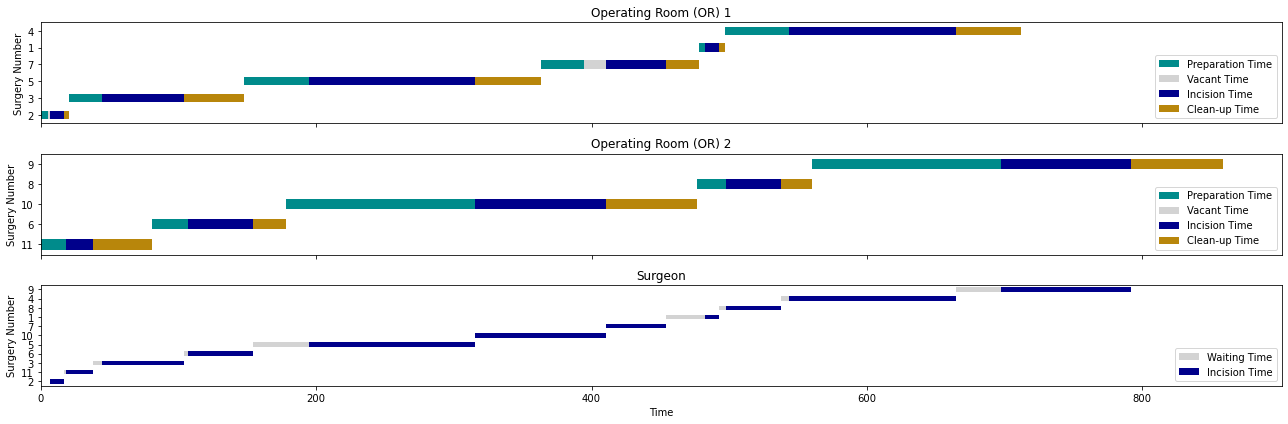

In [50]:
#Overiew of the surgery location
headers_sur_tab_P4 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_P4 = pd.DataFrame(columns = headers_sur_tab_P4)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_P4.loc[len(result_sur_tab_P4),headers_sur_tab_P4[h]] = s
    s+=1
    h+=1
    result_sur_tab_P4.loc[len(result_sur_tab_P4)-1,headers_sur_tab_P4[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_P4.loc[len(result_sur_tab_P4)-1,headers_sur_tab_P4[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_P4 = result_sur_tab_P4.loc[result_sur_tab_P4["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_P4["Surgery Number"].tolist()):
    result_OR1_tab_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_P4["Surgery Number"].tolist():
    result_OR1_tab_P4["Order"] = result_OR1_tab_P4["Beginning of Incision Time"].rank()
result_OR1_tab_P4.sort_values(by="Order", inplace = True)
result_OR1_tab_P4.reset_index(drop = True, inplace = True)
result_OR1_tab_P4.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_P4["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_P4)-1:
        result_OR1_tab_P4.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_P4["Surgery Number"].tolist()):
    result_OR1_tab_P4.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_P4.loc[idx,"End of Preparation Time"] = result_OR1_tab_P4.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_P4.loc[idx,"Preparation Time"]
    result_OR1_tab_P4.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_P4.loc[idx,"End of Preparation Time"]
    result_OR1_tab_P4.loc[idx,"Vacant Time"] = round(result_OR1_tab_P4.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_P4.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_P4.loc[idx,"End of Vacant Time"] = result_OR1_tab_P4.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_P4.loc[idx,"Vacant Time"]
    result_OR1_tab_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_P4.loc[idx,"End of Incision Time"] = result_OR1_tab_P4.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_P4.loc[idx,"Incision Time"]
    result_OR1_tab_P4.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_P4.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_P4.loc[idx,"End of Clean-up Time"] = result_OR1_tab_P4.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_P4.loc[idx,"Clean-up Time"]
result_OR1_tab_P4 = result_OR1_tab_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_P4["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_P4.loc[len(result_OR1_tab_P4)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_P4["Maximum Normal Shift Time"] = ""
result_OR1_tab_P4.loc[len(result_OR1_tab_P4)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_P4["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_P4.loc[len(result_OR1_tab_P4)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_P4 = result_OR1_tab_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_P4 = result_sur_tab_P4.loc[result_sur_tab_P4["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_P4["Surgery Number"].tolist()):
    result_OR2_tab_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_P4["Surgery Number"].tolist():
    result_OR2_tab_P4["Order"] = result_OR2_tab_P4["Beginning of Incision Time"].rank()
result_OR2_tab_P4.sort_values(by="Order", inplace = True)
result_OR2_tab_P4.reset_index(drop = True, inplace = True)
result_OR2_tab_P4.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_P4["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_P4)-1:
        result_OR2_tab_P4.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_P4["Surgery Number"].tolist()):
    result_OR2_tab_P4.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_P4.loc[idx,"End of Preparation Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_P4.loc[idx,"Preparation Time"]
    result_OR2_tab_P4.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_P4.loc[idx,"End of Preparation Time"]
    result_OR2_tab_P4.loc[idx,"Vacant Time"] = round(result_OR2_tab_P4.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_P4.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_P4.loc[idx,"End of Vacant Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_P4.loc[idx,"Vacant Time"]
    result_OR2_tab_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_P4.loc[idx,"End of Incision Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_P4.loc[idx,"Incision Time"]
    result_OR2_tab_P4.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_P4.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_P4.loc[idx,"End of Clean-up Time"] = result_OR2_tab_P4.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_P4.loc[idx,"Clean-up Time"]
result_OR2_tab_P4["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_P4.loc[len(result_OR2_tab_P4)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_P4["Maximum Normal Shift Time"] = ""
result_OR2_tab_P4.loc[len(result_OR2_tab_P4)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_P4["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_P4.loc[len(result_OR2_tab_P4)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_P4 = result_OR2_tab_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_P4 = result_sur_tab_P4.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_P4["Surgery Number"].tolist()):
    result_surgeons_tab_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_P4["Surgery Number"].tolist():
    result_surgeons_tab_P4["Order"] = result_surgeons_tab_P4["Beginning of Incision Time"].rank()
result_surgeons_tab_P4.sort_values(by="Order", inplace = True)
result_surgeons_tab_P4.reset_index(drop = True, inplace = True)
result_surgeons_tab_P4["Start Time of Surgeon"] = 0
result_surgeons_tab_P4.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_P4.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P4["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P4)-1:
        result_surgeons_tab_P4.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_P4.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_P4["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_P4)-1:
        result_surgeons_tab_P4.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_P4.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_P4.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_P4["Surgery Number"].tolist()):
    result_surgeons_tab_P4.loc[idx,"End of Waiting Time"] = result_surgeons_tab_P4.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_P4.loc[idx,"Waiting Time"]
    result_surgeons_tab_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_P4.loc[idx,"End of Incision Time"] = result_surgeons_tab_P4.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_P4.loc[idx,"Incision Time"]
result_surgeons_tab_P4 = result_surgeons_tab_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_P4 = result_sur_tab_P4.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_P4 = result_OR1_tab_P4.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_P4 = result_OR2_tab_P4.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_P4 = result_surgeons_tab_P4.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_P4 = headers_cost_tab_P4 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_P4 = pd.DataFrame(columns = headers_cost_tab_P4)
h=0
result_cost_tab_P4.loc[len(result_cost_tab_P4), headers_cost_tab_P4[h]] = O[1].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = O[2].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = co/60
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = VT[1].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = VT[2].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = cv/60
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = WT.solution_value
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = cw/60
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, headers_cost_tab_P4[h]] = result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, "Total OR Vacant Time Cost"]+result_cost_tab_P4.loc[len(result_cost_tab_P4)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_P4, (result_OR1_plot_P4, result_OR2_plot_P4, result_surgeons_plot_P4) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_P4 = result_OR1_tab_P4.plot.barh(ax = result_OR1_plot_P4, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_P4.set_xlabel("Time")
result_OR1_plot_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_P4 = result_OR2_tab_P4.plot.barh(ax = result_OR2_plot_P4, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_P4.set_xlabel("Time")
result_OR2_plot_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_P4 = result_surgeons_tab_P4.plot.barh(ax = result_surgeons_plot_P4, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_P4.set_xlabel("Time")
result_surgeons_plot_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_P4.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [51]:
print(result_sur_tab_P4)
print(result_OR1_tab_P4)
print(result_OR2_tab_P4)
print(result_surgeons_tab_P4)
print(result_cost_tab_P4)

               Surgery Type Location
Surgery Number                      
1                         A     OR 1
2                         A     OR 1
3                         C     OR 1
4                         E     OR 1
5                         E     OR 1
6                         F     OR 2
7                         G     OR 1
8                         H     OR 2
9                         I     OR 2
10                        I     OR 2
11                        J     OR 2
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
2                                A    1.0                          0.000   
3                                C    2.0                         20.719   
5                                E    3.0                        147.740   
7                                G    4.0                        362.912   
1                                A    5.0                      

##### Export the results

In [52]:
with pd.ExcelWriter("SurgeryScheduling_Mean_P4.xlsx") as writer:
    result_sur_tab_P4.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_P4.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_P4.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_P4.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_P4.to_excel(writer, sheet_name = "Cost")   

In [53]:
figure_P4.savefig("Timeline_Mean_P4.pdf", bbox_inches="tight")
figure_P4.savefig("Timeline_Mean_P4.png", bbox_inches="tight")

#### Cost comparison of the 4 instances 

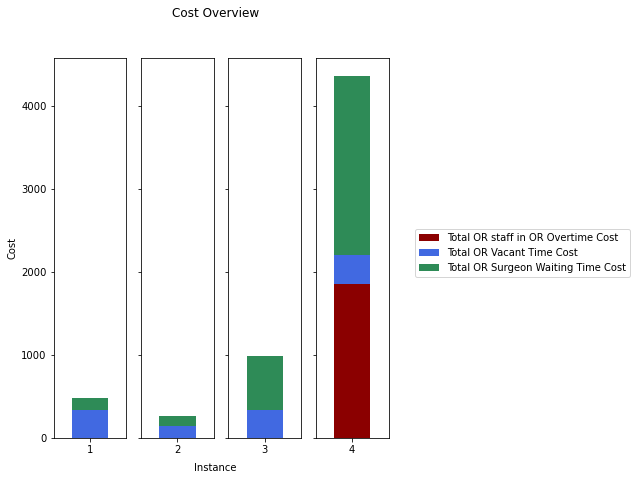

In [54]:
figure_cost_Q1, (cost_plot_P1, cost_plot_P2, cost_plot_P3, cost_plot_P4) = plt.subplots(nrows=1, ncols=4, sharey = True)

cost_plot_P1 = result_cost_tab_P1[["Total OR staff in OR Overtime Cost", "Total OR Vacant Time Cost", "Total OR Surgeon Waiting Time Cost"]].plot.bar(ax = cost_plot_P1, stacked = True, color = ["darkred", "royalblue", "seagreen"], figsize = (6,7), legend = None)
cost_plot_P1.set_xticklabels("1", rotation = "horizontal")
cost_plot_P1.set_ylabel("Cost")
plt.show

cost_plot_P2 = result_cost_tab_P2[["Total OR staff in OR Overtime Cost", "Total OR Vacant Time Cost", "Total OR Surgeon Waiting Time Cost"]].plot.bar(ax = cost_plot_P2, stacked = True, color = ["darkred", "royalblue", "seagreen"], figsize = (6,7), legend = None)
cost_plot_P2.set_xticklabels("2", rotation = "horizontal")
cost_plot_P2.set_ylabel("Cost")
plt.show

cost_plot_P3 = result_cost_tab_P3[["Total OR staff in OR Overtime Cost", "Total OR Vacant Time Cost", "Total OR Surgeon Waiting Time Cost"]].plot.bar(ax = cost_plot_P3, stacked = True, color = ["darkred", "royalblue", "seagreen"], figsize = (6,7), legend = None)
cost_plot_P3.set_xticklabels("3", rotation = "horizontal")
cost_plot_P3.set_ylabel("Cost")
plt.show

cost_plot_P4 = result_cost_tab_P4[["Total OR staff in OR Overtime Cost", "Total OR Vacant Time Cost", "Total OR Surgeon Waiting Time Cost"]].plot.bar(ax = cost_plot_P4, stacked = True, color = ["darkred", "royalblue", "seagreen"], figsize = (6,7), legend = None)
cost_plot_P4.set_xticklabels("4", rotation = "horizontal")
cost_plot_P4.set_ylabel("Cost")
plt.show

figure_cost_Q1.suptitle("Cost Overview")
figure_cost_Q1.text(0.5, 0.06, "Instance", ha='center')
handles, labels = cost_plot_P4.get_legend_handles_labels()
figure_cost_Q1.legend(handles, labels, bbox_to_anchor=(0.95, 0.45), loc='center left')

##### Export the results

In [55]:
figure_cost_Q1.savefig("Cost_Mean_Q1.pdf", bbox_inches="tight")
figure_cost_Q1.savefig("Cost_Mean_Q1.png", bbox_inches="tight")

### 2) Stochastic case

#### Problem Instance 1

##### Create the model instance

In [56]:
model_stoc_P1 = Model("SurgerySchedulingStochastic_P1")

##### Define all sets

In [57]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

scenarios = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A", nrows = 100, skiprows = 2)
scenarios = scenarios.index.tolist()
scenarios = [1]+[i+2 for i in scenarios]
scenarios_fin = ["s"+str(i) for i in scenarios] #100 different scenarios with different preparation time, incision time and clean-up time
prob_s = (max(scenarios)/len(scenarios))/100 #Probability of each scenario is assumed to be equal

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 2)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 1)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:G", nrows = 1, skiprows = 1)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp["Scenarios"] = scenarios_fin
tp = tp.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Preparation time of each surgery type in different scenarios (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts.columns = tp.columns
ts["Scenarios"] = scenarios_fin
ts = ts.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Incision time of each surgery type in different scenarios (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc.columns = tp.columns
tc["Scenarios"] = scenarios_fin
tc = tc.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Clean-up time of each surgery type in different scenarios (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [58]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4]
['A', 'A', 'C', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'J'}
                             A     B     C     D     E     F     G     H  \
Scenarios | Surgery Type                                                   
s1                        11.8  29.7  29.0  28.3  79.0  37.4  28.7  30.3   
s2                         2.2  43.0  34.4  13.9  31.0  27.3  31.4  15.1   
s3                         4.1  80.4  36.9  15.1  78.8  45.6  25.2  16.3   
s4                         4.6  37.1  21.2  23.8  27.5  21.0  62.2  21.3   
s5                         6.2  40.8  37.4   9.7  25.6  36.9  21.3  20.9   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
s96                        5.8  26.1  22.9   8.7  72.2  47.3  41.6  15.1   
s97                        9.9  34.7  22.2  12.7  60.3  23.6  45.2  28.2   
s98                        9.0  41.8  21.3  16.6  45.7  43.9  22.4  26.6   
s99                        5.0  28.5  12.9  23.9  46.5  24.0  24.7  20.8   
s100      

##### Define the decision variables

In [59]:
X = model_stoc_P1.continuous_var_matrix(surgery, scenarios_fin, name = "start_sur") #Start time of the incision of surgery i in scenario s (in min)
SMS = model_stoc_P1.continuous_var_dict(scenarios_fin, name = "surgeon_makespan") #Time when surgeon finishes last incision in scenario s (in min)
WT = model_stoc_P1.continuous_var_dict(scenarios_fin, name = "surgeon_wait") #Surgeon's total waiting time within the whole shift in scenario s (in min)
Y = model_stoc_P1.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_stoc_P1.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_stoc_P1.continuous_var_matrix(rooms, scenarios_fin, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up in scenario s (in min)
VT = model_stoc_P1.continuous_var_matrix(rooms, scenarios_fin, name = "OR_vacant") #OR's total vacant time within the whole shift in scenario s (in min)
O = model_stoc_P1.continuous_var_matrix(rooms, scenarios_fin, name = "OR_ot") #OR staff overtime in OR r in scenario s (in min)
F = model_stoc_P1.continuous_var_matrix(rooms, scenarios_fin, name = "Or_unused") #OR r's unused normal shift time in scenario s (in min)
S = model_stoc_P1.continuous_var_dict(scenarios_fin, name = "surgeon_begin") #Start time of the surgeon in his first surgery in scenario s (in min)

##### Define all constraints

In [60]:
#The earliest start time of a surgery incision
model_stoc_P1.add_constraints(X[i,s] >= tp.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_stoc_P1.add_constraints(S[s] <= X[i,s] for s in scenarios_fin for i in surgery) #The start time of the surgeon
model_stoc_P1.add_constraints(SMS[s] >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The latest incision finishing time
model_stoc_P1.add_constraints(WT[s] == SMS[s]-model_stoc_P1.sum(ts.loc[s,sur_type[i]] for i in surgery)-S[s] for s in scenarios_fin) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_stoc_P1.add_constraints(X[j,s]+big_M*(1-Y[i,j]) >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_stoc_P1.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_stoc_P1.add_constraints(ORMS[r,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+(W[i,r]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery) #The latest clean-up finishing time
model_stoc_P1.add_constraints(ORMS[r,s] == T+O[r,s]-F[r,s] for s in scenarios_fin for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_stoc_P1.add_constraints(VT[r,s] == ORMS[r,s]-model_stoc_P1.sum(W[i,r]*(tp.loc[s,sur_type[i]]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]) for i in surgery) for s in scenarios_fin for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_stoc_P1.add_constraints(X[j,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+tp.loc[s,sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_stoc_P1.add_constraints(model_stoc_P1.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1)]

##### Define linear expression

In [61]:
J = model_stoc_P1.sum((prob_s*(model_stoc_P1.sum(((O[r,s]/60)*co) for r in rooms))) for s in scenarios_fin)+model_stoc_P1.sum((prob_s*(model_stoc_P1.sum(((VT[r,s]/60)*cv) for r in rooms))) for s in scenarios_fin)+model_stoc_P1.sum((prob_s*((WT[s]/60)*cw)) for s in scenarios_fin)

##### Define the objective function

In [62]:
model_stoc_P1.minimize(J)

##### Solve the model

In [63]:
model_stoc_P1.solve()

docplex.mp.solution.SolveSolution(obj=646.221,values={start_sur_1_s1:15...

In [64]:
model_stoc_P1.solve_details
model_stoc_P1.report()
model_stoc_P1.print_information()
model_stoc_P1.print_solution()
model_stoc_P1.get_solve_status()

* model SurgerySchedulingStochastic_P1 solved with objective = 646.221
Model: SurgerySchedulingStochastic_P1
 - number of variables: 1524
   - binary=24, integer=0, continuous=1500
 - number of constraints: 6116
   - linear=6116
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 646.221
  start_sur_1_s1=15.100
  start_sur_1_s2=13.800
  start_sur_1_s3=13.600
  start_sur_1_s4=9.400
  start_sur_1_s5=15.400
  start_sur_1_s6=12.200
  start_sur_1_s7=12.600
  start_sur_1_s8=10.500
  start_sur_1_s9=18.000
  start_sur_1_s10=16.400
  start_sur_1_s11=16.900
  start_sur_1_s12=12.300
  start_sur_1_s13=11.000
  start_sur_1_s14=13.400
  start_sur_1_s15=21.200
  start_sur_1_s16=14.500
  start_sur_1_s17=11.800
  start_sur_1_s18=9.600
  start_sur_1_s19=14.000
  start_sur_1_s20=12.700
  start_sur_1_s21=30.400
  start_sur_1_s22=19.600
  start_sur_1_s23=14.000
  start_sur_1_s24=21.700
  start_sur_1_s25=19.400
  start_sur_1_s26=11.800
  start_sur_1_s27=12.200
  start_sur_1_s2

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

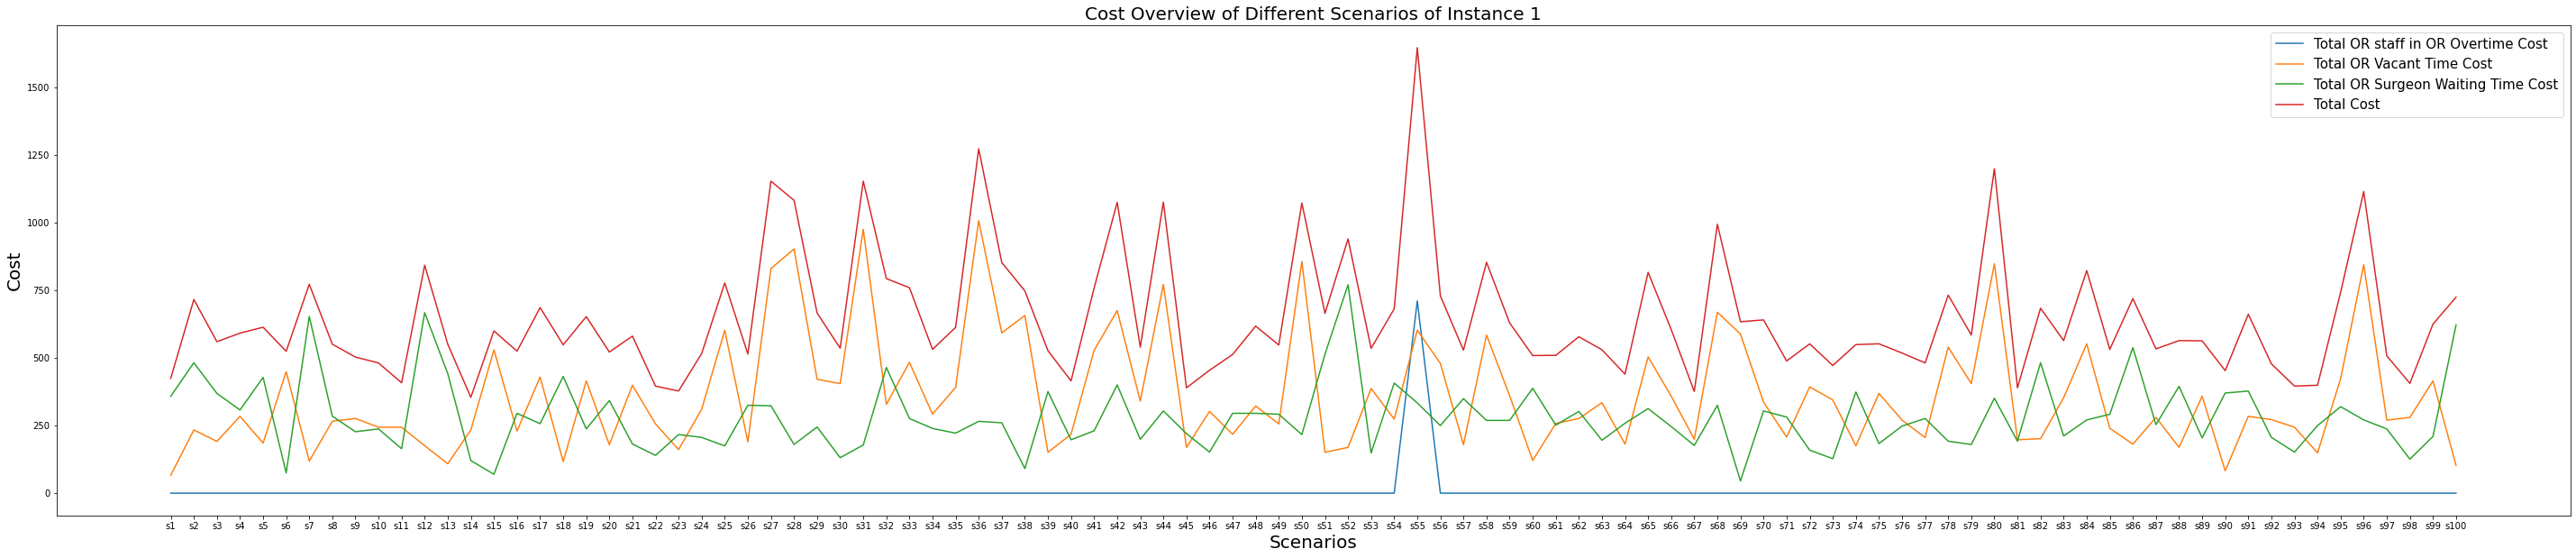

In [65]:
#Overiew of the surgery location and sequence
sur_seq_tab_stoc_P1 = pd.DataFrame(index = [i for i in surgery], columns = [j for j in surgery])
for i in surgery:
    for j in surgery:
        sur_seq_tab_stoc_P1.loc[i,j] = Y[i,j].solution_value
sur_seq_tab_stoc_P1["Indicator for Ranking"] = sur_seq_tab_stoc_P1.sum(axis = 1).astype(int)
for i in surgery:
    for r in rooms:
        if W[i,r].solution_value == 1:
            sur_seq_tab_stoc_P1.loc[i,"Location"] = "OR "+ str(r)
sur_OR1_seq_tab_stoc_P1 = sur_seq_tab_stoc_P1.loc[sur_seq_tab_stoc_P1["Location"]=="OR 1"].copy(deep = True)
for i in range(len(sur_OR1_seq_tab_stoc_P1.index.tolist())):
    sur_OR1_seq_tab_stoc_P1["Order"] = sur_OR1_seq_tab_stoc_P1["Indicator for Ranking"].rank(ascending = False)
sur_OR2_seq_tab_stoc_P1 = sur_seq_tab_stoc_P1.loc[sur_seq_tab_stoc_P1["Location"]=="OR 2"].copy(deep = True)
for i in range(len(sur_OR2_seq_tab_stoc_P1.index.tolist())):
    sur_OR2_seq_tab_stoc_P1["Order"] = sur_OR2_seq_tab_stoc_P1["Indicator for Ranking"].rank(ascending = False)
sur_all_seq_tab_stoc_P1 = pd.concat([sur_OR1_seq_tab_stoc_P1,sur_OR2_seq_tab_stoc_P1])
        
headers_sur_tab_stoc_P1 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_stoc_P1 = pd.DataFrame(columns = headers_sur_tab_stoc_P1)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_stoc_P1.loc[len(result_sur_tab_stoc_P1),headers_sur_tab_stoc_P1[h]] = s
    s+=1
    h+=1
    result_sur_tab_stoc_P1.loc[len(result_sur_tab_stoc_P1)-1,headers_sur_tab_stoc_P1[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_stoc_P1.loc[len(result_sur_tab_stoc_P1)-1,headers_sur_tab_stoc_P1[h]] = "OR "+ str(r)
result_sur_tab_stoc_P1 = result_sur_tab_stoc_P1.set_index("Surgery Number")
for i in surgery:
    result_sur_tab_stoc_P1.loc[i, "Order"] = sur_all_seq_tab_stoc_P1.loc[i, "Order"]
result_sur_tab_stoc_P1 = result_sur_tab_stoc_P1.sort_values("Location")

#Overview of cost in different scenarios
headers_cost_tab_stoc_P1 = headers_cost_tab_stoc_P1 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_stoc_P1 = pd.DataFrame(columns = headers_cost_tab_stoc_P1)
for s in scenarios_fin:
    h=0
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1), headers_cost_tab_stoc_P1[h]] = O[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = O[1,s].solution_value+O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = co/60
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = (O[1,s].solution_value+O[2,s].solution_value)*(co/60)
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = VT[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = VT[1,s].solution_value+VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = cv/60
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = (VT[1,s].solution_value+VT[2,s].solution_value)*(cv/60)
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = WT[s].solution_value
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = cw/60
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = WT[s].solution_value*(cw/60)
    h+=1
    result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, headers_cost_tab_stoc_P1[h]] = result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, "Total OR Vacant Time Cost"]+result_cost_tab_stoc_P1.loc[len(result_cost_tab_stoc_P1)-1, "Total OR Surgeon Waiting Time Cost"]
result_cost_tab_stoc_P1["Scenarios"] = scenarios_fin
result_cost_tab_stoc_P1 = result_cost_tab_stoc_P1.set_index("Scenarios")

#Overview of cost in different scenarios in graph
cost_plot_stoc_P1 = plt.figure(figsize = (50,10))
plt.plot(result_cost_tab_stoc_P1.index,result_cost_tab_stoc_P1["Total OR staff in OR Overtime Cost"], label = "Total OR staff in OR Overtime Cost")
plt.plot(result_cost_tab_stoc_P1.index,result_cost_tab_stoc_P1["Total OR Vacant Time Cost"], label = "Total OR Vacant Time Cost")
plt.plot(result_cost_tab_stoc_P1.index,result_cost_tab_stoc_P1["Total OR Surgeon Waiting Time Cost"], label = "Total OR Surgeon Waiting Time Cost")
plt.plot(result_cost_tab_stoc_P1.index,result_cost_tab_stoc_P1["Total Cost"], label = "Total Cost")
plt.xlabel("Scenarios", fontsize = 20)
plt.ylabel("Cost", fontsize = 20)
plt.title("Cost Overview of Different Scenarios of Instance 1", fontsize = 20)
plt.legend(fontsize = 15)

##### Export the results

In [66]:
with pd.ExcelWriter("SurgerySchedulingStoc_P1.xlsx") as writer:
    result_cost_tab_stoc_P1.to_excel(writer, sheet_name = "Cost") 
    
cost_plot_stoc_P1.savefig("Stochastic_Cost_P1.pdf", bbox_inches="tight")
cost_plot_stoc_P1.savefig("Stochastic_Cost_P1.png", bbox_inches="tight")

#### Problem Instance 1 (Worst Case Scenario)

##### Create the model instance

In [67]:
model_wor_P1 = Model("SurgeryScheduling_wor_P1")

##### Define all sets

In [68]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 2)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 1)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:G", nrows = 1, skiprows = 1)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.max(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.max(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.max(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [69]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4]
['A', 'A', 'C', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'J'}
{'A': 13.0, 'B': 80.4, 'C': 50.8, 'D': 45.1, 'E': 116.0, 'F': 56.7, 'G': 76.5, 'H': 37.8, 'I': 257.1, 'J': 30.6}
{'A': 19.4, 'B': 163.1, 'C': 139.3, 'D': 105.5, 'E': 289.1, 'F': 112.0, 'G': 114.6, 'H': 81.9, 'I': 346.5, 'J': 56.0}
{'A': 13.5, 'B': 91.8, 'C': 90.0, 'D': 44.1, 'E': 121.9, 'F': 52.6, 'G': 62.8, 'H': 46.7, 'I': 120.2, 'J': 67.7}
1209.6
1048.8
806.4


##### Define the decision variables

In [70]:
X = model_wor_P1.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_wor_P1.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_wor_P1.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_wor_P1.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_wor_P1.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_wor_P1.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_wor_P1.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_wor_P1.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_wor_P1.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_wor_P1.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [71]:
#The earliest start time of a surgery incision
model_wor_P1.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_wor_P1.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_wor_P1.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_wor_P1.add_constraint(WT == SMS-model_wor_P1.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_wor_P1.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_wor_P1.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_wor_P1.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_wor_P1.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_wor_P1.add_constraints(VT[r] == ORMS[r]-model_wor_P1.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_wor_P1.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_wor_P1.add_constraints(model_wor_P1.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1)]

##### Define linear expression

In [72]:
J = model_wor_P1.sum((O[r]/60)*co for r in rooms)+model_wor_P1.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [73]:
model_wor_P1.minimize(J)

##### Solve the model

In [74]:
model_wor_P1.solve()

docplex.mp.solution.SolveSolution(obj=2790.48,values={start_sur_1:32.4,s..

In [75]:
model_wor_P1.solve_details
model_wor_P1.report()
model_wor_P1.print_information()
model_wor_P1.print_solution()
model_wor_P1.get_solve_status()

* model SurgeryScheduling_wor_P1 solved with objective = 2790.476
Model: SurgeryScheduling_wor_P1
 - number of variables: 39
   - binary=24, integer=0, continuous=15
 - number of constraints: 77
   - linear=77
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 2790.476
  start_sur_1=32.400
  start_sur_2=13.000
  start_sur_3=132.500
  start_sur_4=76.500
  surgeon_makespan=271.800
  surgeon_wait=24.700
  order_1_3=1
  order_1_4=1
  order_2_1=1
  order_2_3=1
  order_2_4=1
  order_4_3=1
  perform_1_1=1
  perform_2_2=1
  perform_3_1=1
  perform_4_2=1
  OR_makespan_1=361.800
  OR_makespan_2=200.200
  OR_vacant_1=35.800
  OR_ot_1=121.800
  Or_unused_2=39.800
  surgeon_begin=13.000


<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-76-6eb8fb6ec0c3>:166: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_wor_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-76-6eb8fb6ec0c3>:174: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_wor_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-76-6eb8fb6ec0c3>:182: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_wor_P1.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


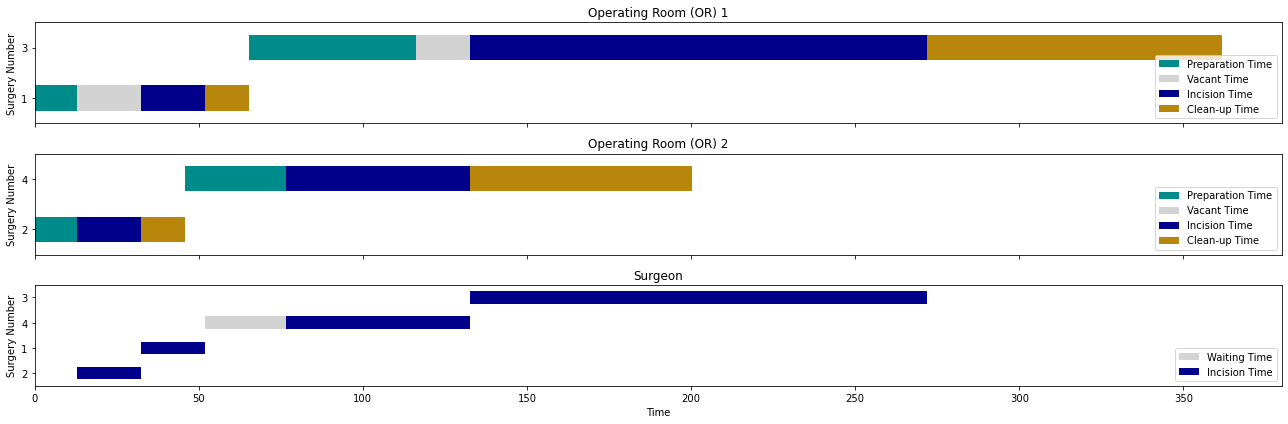

In [76]:
#Overiew of the surgery location
headers_sur_tab_wor_P1 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_wor_P1 = pd.DataFrame(columns = headers_sur_tab_wor_P1)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_wor_P1.loc[len(result_sur_tab_wor_P1),headers_sur_tab_wor_P1[h]] = s
    s+=1
    h+=1
    result_sur_tab_wor_P1.loc[len(result_sur_tab_wor_P1)-1,headers_sur_tab_wor_P1[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_wor_P1.loc[len(result_sur_tab_wor_P1)-1,headers_sur_tab_wor_P1[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_wor_P1 = result_sur_tab_wor_P1.loc[result_sur_tab_wor_P1["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_wor_P1["Surgery Number"].tolist()):
    result_OR1_tab_wor_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_wor_P1["Surgery Number"].tolist():
    result_OR1_tab_wor_P1["Order"] = result_OR1_tab_wor_P1["Beginning of Incision Time"].rank()
result_OR1_tab_wor_P1.sort_values(by="Order", inplace = True)
result_OR1_tab_wor_P1.reset_index(drop = True, inplace = True)
result_OR1_tab_wor_P1.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_wor_P1["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_wor_P1)-1:
        result_OR1_tab_wor_P1.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_wor_P1["Surgery Number"].tolist()):
    result_OR1_tab_wor_P1.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_wor_P1.loc[idx,"End of Preparation Time"] = result_OR1_tab_wor_P1.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_wor_P1.loc[idx,"Preparation Time"]
    result_OR1_tab_wor_P1.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_wor_P1.loc[idx,"End of Preparation Time"]
    result_OR1_tab_wor_P1.loc[idx,"Vacant Time"] = round(result_OR1_tab_wor_P1.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_wor_P1.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_wor_P1.loc[idx,"End of Vacant Time"] = result_OR1_tab_wor_P1.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_wor_P1.loc[idx,"Vacant Time"]
    result_OR1_tab_wor_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_wor_P1.loc[idx,"End of Incision Time"] = result_OR1_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_wor_P1.loc[idx,"Incision Time"]
    result_OR1_tab_wor_P1.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_wor_P1.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_wor_P1.loc[idx,"End of Clean-up Time"] = result_OR1_tab_wor_P1.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_wor_P1.loc[idx,"Clean-up Time"]
result_OR1_tab_wor_P1 = result_OR1_tab_wor_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_wor_P1["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_wor_P1.loc[len(result_OR1_tab_wor_P1)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_wor_P1["Maximum Normal Shift Time"] = ""
result_OR1_tab_wor_P1.loc[len(result_OR1_tab_wor_P1)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_wor_P1["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_wor_P1.loc[len(result_OR1_tab_wor_P1)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_wor_P1 = result_OR1_tab_wor_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_wor_P1 = result_sur_tab_wor_P1.loc[result_sur_tab_wor_P1["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_wor_P1["Surgery Number"].tolist()):
    result_OR2_tab_wor_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_wor_P1["Surgery Number"].tolist():
    result_OR2_tab_wor_P1["Order"] = result_OR2_tab_wor_P1["Beginning of Incision Time"].rank()
result_OR2_tab_wor_P1.sort_values(by="Order", inplace = True)
result_OR2_tab_wor_P1.reset_index(drop = True, inplace = True)
result_OR2_tab_wor_P1.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_wor_P1["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_wor_P1)-1:
        result_OR2_tab_wor_P1.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_wor_P1["Surgery Number"].tolist()):
    result_OR2_tab_wor_P1.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_wor_P1.loc[idx,"End of Preparation Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_wor_P1.loc[idx,"Preparation Time"]
    result_OR2_tab_wor_P1.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_wor_P1.loc[idx,"End of Preparation Time"]
    result_OR2_tab_wor_P1.loc[idx,"Vacant Time"] = round(result_OR2_tab_wor_P1.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_wor_P1.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_wor_P1.loc[idx,"End of Vacant Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_wor_P1.loc[idx,"Vacant Time"]
    result_OR2_tab_wor_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_wor_P1.loc[idx,"End of Incision Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_wor_P1.loc[idx,"Incision Time"]
    result_OR2_tab_wor_P1.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_wor_P1.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_wor_P1.loc[idx,"End of Clean-up Time"] = result_OR2_tab_wor_P1.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_wor_P1.loc[idx,"Clean-up Time"]
result_OR2_tab_wor_P1["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_wor_P1.loc[len(result_OR2_tab_wor_P1)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_wor_P1["Maximum Normal Shift Time"] = ""
result_OR2_tab_wor_P1.loc[len(result_OR2_tab_wor_P1)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_wor_P1["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_wor_P1.loc[len(result_OR2_tab_wor_P1)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_wor_P1 = result_OR2_tab_wor_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_wor_P1 = result_sur_tab_wor_P1.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_wor_P1["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P1.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_wor_P1["Surgery Number"].tolist():
    result_surgeons_tab_wor_P1["Order"] = result_surgeons_tab_wor_P1["Beginning of Incision Time"].rank()
result_surgeons_tab_wor_P1.sort_values(by="Order", inplace = True)
result_surgeons_tab_wor_P1.reset_index(drop = True, inplace = True)
result_surgeons_tab_wor_P1["Start Time of Surgeon"] = 0
result_surgeons_tab_wor_P1.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_wor_P1.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P1["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P1)-1:
        result_surgeons_tab_wor_P1.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_wor_P1.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P1["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P1)-1:
        result_surgeons_tab_wor_P1.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_wor_P1.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_wor_P1.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_wor_P1["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P1.loc[idx,"End of Waiting Time"] = result_surgeons_tab_wor_P1.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_wor_P1.loc[idx,"Waiting Time"]
    result_surgeons_tab_wor_P1.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_wor_P1.loc[idx,"End of Incision Time"] = result_surgeons_tab_wor_P1.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_wor_P1.loc[idx,"Incision Time"]
result_surgeons_tab_wor_P1 = result_surgeons_tab_wor_P1.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_wor_P1 = result_sur_tab_wor_P1.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_wor_P1 = result_OR1_tab_wor_P1.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_wor_P1 = result_OR2_tab_wor_P1.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_wor_P1 = result_surgeons_tab_wor_P1.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_wor_P1 = headers_cost_tab_wor_P1 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_wor_P1 = pd.DataFrame(columns = headers_cost_tab_wor_P1)
h=0
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1), headers_cost_tab_wor_P1[h]] = O[1].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = O[2].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = co/60
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = VT[1].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = VT[2].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = cv/60
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = WT.solution_value
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = cw/60
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, headers_cost_tab_wor_P1[h]] = result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, "Total OR Vacant Time Cost"]+result_cost_tab_wor_P1.loc[len(result_cost_tab_wor_P1)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_wor_P1, (result_OR1_plot_wor_P1, result_OR2_plot_wor_P1, result_surgeons_plot_wor_P1) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_wor_P1 = result_OR1_tab_wor_P1.plot.barh(ax = result_OR1_plot_wor_P1, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_wor_P1.set_xlabel("Time")
result_OR1_plot_wor_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_wor_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_wor_P1 = result_OR2_tab_wor_P1.plot.barh(ax = result_OR2_plot_wor_P1, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_wor_P1.set_xlabel("Time")
result_OR2_plot_wor_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_wor_P1.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_wor_P1 = result_surgeons_tab_wor_P1.plot.barh(ax = result_surgeons_plot_wor_P1, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_wor_P1.set_xlabel("Time")
result_surgeons_plot_wor_P1.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_wor_P1.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [77]:
print(result_sur_tab_wor_P1)
print(result_OR1_tab_wor_P1)
print(result_OR2_tab_wor_P1)
print(result_surgeons_tab_wor_P1)
print(result_cost_tab_wor_P1)

               Surgery Type Location
Surgery Number                      
1                         A     OR 1
2                         A     OR 2
3                         C     OR 1
4                         J     OR 2
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
1                                A    1.0                            0.0   
3                                C    2.0                           65.3   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
1                                  13.0                     13.0   
3                                  50.8                    116.1   

                       Beginning of Vacant Time  Vacant Time  \
Surgery Number | OR 1                                          
1                                          13.0         19.4   
3       

##### Export the results

In [78]:
with pd.ExcelWriter("SurgeryScheduling_Worst_P1.xlsx") as writer:
    result_sur_tab_wor_P1.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_wor_P1.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_wor_P1.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_wor_P1.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_wor_P1.to_excel(writer, sheet_name = "Cost")   

In [79]:
figure_wor_P1.savefig("Timeline_Worst_P1.pdf", bbox_inches="tight")
figure_wor_P1.savefig("Timeline_Worst_P1.png", bbox_inches="tight")

#### Problem Instance 1 (Comparison of Scenarios Case, Mean Case and Worst Case)

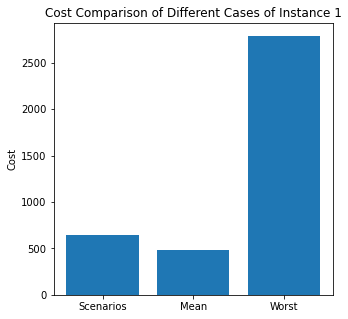

In [80]:
#Objective value comparison
x_comp_P1 = ["Scenarios", "Mean", "Worst"]
y_comp_P1 = [model_stoc_P1.objective_value, model_P1.objective_value, model_wor_P1.objective_value]
cost_plot_comp_P1 = plt.figure(figsize = (5,5))
plt.bar(x_comp_P1, y_comp_P1)
plt.ylabel("Cost")
plt.title("Cost Comparison of Different Cases of Instance 1")

#Location and sequence comparison
result_OR1_tab_P1["Location"] = "OR 1"
result_OR1_tab_P1 = result_OR1_tab_P1.reset_index()
result_OR1_tab_P1.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_P1["Location"] = "OR 2"
result_OR2_tab_P1 = result_OR2_tab_P1.reset_index()
result_OR2_tab_P1.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_mean_P1 = pd.concat([result_OR1_tab_P1, result_OR2_tab_P1])
result_all_tab_mean_P1.rename(columns = {"Surgery Number":"Surgery Number | Mean Case"}, inplace = True)
result_all_tab_mean_P1 = result_all_tab_mean_P1.reindex(columns = ["Surgery Number | Mean Case","Surgery Type","Location","Order"])
result_all_tab_mean_P1 = result_all_tab_mean_P1.reset_index(drop = True)

result_OR1_tab_wor_P1["Location"] = "OR 1"
result_OR1_tab_wor_P1 = result_OR1_tab_wor_P1.reset_index()
result_OR1_tab_wor_P1.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_wor_P1["Location"] = "OR 2"
result_OR2_tab_wor_P1 = result_OR2_tab_wor_P1.reset_index()
result_OR2_tab_wor_P1.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_wor_P1 = pd.concat([result_OR1_tab_wor_P1, result_OR2_tab_wor_P1])
result_all_tab_wor_P1.rename(columns = {"Surgery Number":"Surgery Number | Worst Case"}, inplace = True)
result_all_tab_wor_P1 = result_all_tab_wor_P1.reindex(columns = ["Surgery Number | Worst Case","Surgery Type","Location","Order"])
result_all_tab_wor_P1 = result_all_tab_wor_P1.reset_index(drop = True)

result_sur_tab_stoc_P1 = result_sur_tab_stoc_P1.reset_index()
result_sur_tab_stoc_P1.rename(columns = {"Surgery Number":"Surgery Number | Scenarios Case"}, inplace = True)

result_all_sur_tab_stoc_P1 = pd.concat([result_sur_tab_stoc_P1,result_all_tab_mean_P1,result_all_tab_wor_P1], axis = 1)


##### Export the results

In [81]:
with pd.ExcelWriter("SurgeryScheduling_Comp_P1.xlsx") as writer:
    result_all_sur_tab_stoc_P1.to_excel(writer, sheet_name = "Cases Comparison_P1")

cost_plot_comp_P1.savefig("CostComparison_P1.pdf", bbox_inches="tight")
cost_plot_comp_P1.savefig("CostComparison_P1.png", bbox_inches="tight")

#### Problem Instance 2

##### Create the model instance

In [82]:
model_stoc_P2 = Model("SurgerySchedulingStochastic_P2")

##### Define all sets

In [83]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

scenarios = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A", nrows = 100, skiprows = 2)
scenarios = scenarios.index.tolist()
scenarios = [1]+[i+2 for i in scenarios]
scenarios_fin = ["s"+str(i) for i in scenarios] #100 different scenarios with different preparation time, incision time and clean-up time
prob_s = (max(scenarios)/len(scenarios))/100 #Probability of each scenario is assumed to be equal

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 3)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 2)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:H", nrows = 1, skiprows = 2)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp["Scenarios"] = scenarios_fin
tp = tp.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Preparation time of each surgery type in different scenarios (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts.columns = tp.columns
ts["Scenarios"] = scenarios_fin
ts = ts.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Incision time of each surgery type in different scenarios (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc.columns = tp.columns
tc["Scenarios"] = scenarios_fin
tc = tc.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Clean-up time of each surgery type in different scenarios (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [84]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4, 5]
['A', 'D', 'G', 'G', 'J']
{1: 'A', 2: 'D', 3: 'G', 4: 'G', 5: 'J'}
                             A     B     C     D     E     F     G     H  \
Scenarios | Surgery Type                                                   
s1                        11.8  29.7  29.0  28.3  79.0  37.4  28.7  30.3   
s2                         2.2  43.0  34.4  13.9  31.0  27.3  31.4  15.1   
s3                         4.1  80.4  36.9  15.1  78.8  45.6  25.2  16.3   
s4                         4.6  37.1  21.2  23.8  27.5  21.0  62.2  21.3   
s5                         6.2  40.8  37.4   9.7  25.6  36.9  21.3  20.9   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
s96                        5.8  26.1  22.9   8.7  72.2  47.3  41.6  15.1   
s97                        9.9  34.7  22.2  12.7  60.3  23.6  45.2  28.2   
s98                        9.0  41.8  21.3  16.6  45.7  43.9  22.4  26.6   
s99                        5.0  28.5  12.9  23.9  46.5  24.0  24.7  20

##### Define the decision variables

In [85]:
X = model_stoc_P2.continuous_var_matrix(surgery, scenarios_fin, name = "start_sur") #Start time of the incision of surgery i in scenario s (in min)
SMS = model_stoc_P2.continuous_var_dict(scenarios_fin, name = "surgeon_makespan") #Time when surgeon finishes last incision in scenario s (in min)
WT = model_stoc_P2.continuous_var_dict(scenarios_fin, name = "surgeon_wait") #Surgeon's total waiting time within the whole shift in scenario s (in min)
Y = model_stoc_P2.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_stoc_P2.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_stoc_P2.continuous_var_matrix(rooms, scenarios_fin, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up in scenario s (in min)
VT = model_stoc_P2.continuous_var_matrix(rooms, scenarios_fin, name = "OR_vacant") #OR's total vacant time within the whole shift in scenario s (in min)
O = model_stoc_P2.continuous_var_matrix(rooms, scenarios_fin, name = "OR_ot") #OR staff overtime in OR r in scenario s (in min)
F = model_stoc_P2.continuous_var_matrix(rooms, scenarios_fin, name = "Or_unused") #OR r's unused normal shift time in scenario s (in min)
S = model_stoc_P2.continuous_var_dict(scenarios_fin, name = "surgeon_begin") #Start time of the surgeon in his first surgery in scenario s (in min)

##### Define all constraints

In [86]:
#The earliest start time of a surgery incision
model_stoc_P2.add_constraints(X[i,s] >= tp.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_stoc_P2.add_constraints(S[s] <= X[i,s] for s in scenarios_fin for i in surgery) #The start time of the surgeon
model_stoc_P2.add_constraints(SMS[s] >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The latest incision finishing time
model_stoc_P2.add_constraints(WT[s] == SMS[s]-model_stoc_P2.sum(ts.loc[s,sur_type[i]] for i in surgery)-S[s] for s in scenarios_fin) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_stoc_P2.add_constraints(X[j,s]+big_M*(1-Y[i,j]) >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_stoc_P2.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_stoc_P2.add_constraints(ORMS[r,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+(W[i,r]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery) #The latest clean-up finishing time
model_stoc_P2.add_constraints(ORMS[r,s] == T+O[r,s]-F[r,s] for s in scenarios_fin for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_stoc_P2.add_constraints(VT[r,s] == ORMS[r,s]-model_stoc_P2.sum(W[i,r]*(tp.loc[s,sur_type[i]]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]) for i in surgery) for s in scenarios_fin for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_stoc_P2.add_constraints(X[j,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+tp.loc[s,sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_stoc_P2.add_constraints(model_stoc_P2.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1)]

##### Define linear expression

In [87]:
J = model_stoc_P2.sum((prob_s*(model_stoc_P2.sum(((O[r,s]/60)*co) for r in rooms))) for s in scenarios_fin)+model_stoc_P2.sum((prob_s*(model_stoc_P2.sum(((VT[r,s]/60)*cv) for r in rooms))) for s in scenarios_fin)+model_stoc_P2.sum((prob_s*((WT[s]/60)*cw)) for s in scenarios_fin)

##### Define the objective function

In [88]:
model_stoc_P2.minimize(J)

##### Solve the model

In [89]:
model_stoc_P2.solve()

docplex.mp.solution.SolveSolution(obj=1382.85,values={start_sur_1_s1:25,..

In [90]:
model_stoc_P2.solve_details
model_stoc_P2.report()
model_stoc_P2.print_information()
model_stoc_P2.print_solution()
model_stoc_P2.get_solve_status()

* model SurgerySchedulingStochastic_P2 solved with objective = 1382.850
Model: SurgerySchedulingStochastic_P2
 - number of variables: 1635
   - binary=35, integer=0, continuous=1600
 - number of constraints: 9025
   - linear=9025
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 1382.850
  start_sur_1_s1=25.000
  start_sur_1_s2=2.200
  start_sur_1_s3=4.100
  start_sur_1_s4=19.000
  start_sur_1_s5=6.200
  start_sur_1_s6=2.100
  start_sur_1_s7=6.700
  start_sur_1_s8=4.800
  start_sur_1_s9=10.000
  start_sur_1_s10=4.300
  start_sur_1_s11=9.000
  start_sur_1_s12=5.700
  start_sur_1_s13=5.600
  start_sur_1_s14=1.800
  start_sur_1_s15=2.900
  start_sur_1_s16=3.100
  start_sur_1_s17=3.300
  start_sur_1_s18=8.000
  start_sur_1_s19=5.000
  start_sur_1_s20=3.800
  start_sur_1_s21=11.100
  start_sur_1_s22=6.900
  start_sur_1_s23=6.000
  start_sur_1_s24=6.300
  start_sur_1_s25=4.400
  start_sur_1_s26=2.400
  start_sur_1_s27=8.600
  start_sur_1_s28=13.000
  start_su

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

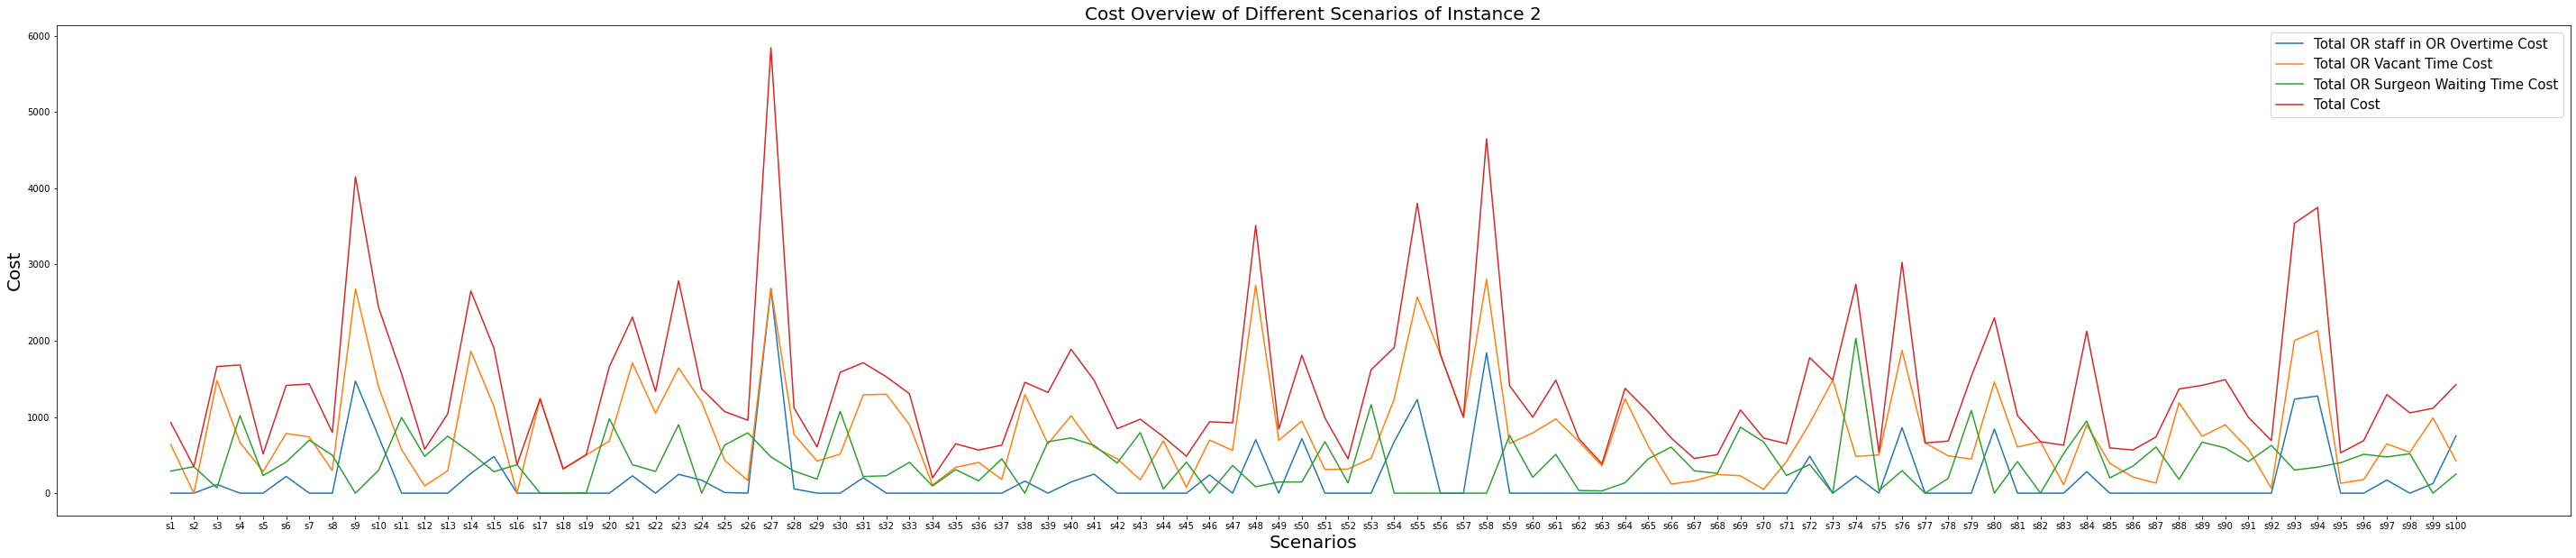

In [91]:
#Overiew of the surgery location and sequence
sur_seq_tab_stoc_P2 = pd.DataFrame(index = [i for i in surgery], columns = [j for j in surgery])
for i in surgery:
    for j in surgery:
        sur_seq_tab_stoc_P2.loc[i,j] = Y[i,j].solution_value
sur_seq_tab_stoc_P2["Indicator for Ranking"] = sur_seq_tab_stoc_P2.sum(axis = 1).astype(int)
for i in surgery:
    for r in rooms:
        if W[i,r].solution_value == 1:
            sur_seq_tab_stoc_P2.loc[i,"Location"] = "OR "+ str(r)
sur_OR1_seq_tab_stoc_P2 = sur_seq_tab_stoc_P2.loc[sur_seq_tab_stoc_P2["Location"]=="OR 1"].copy(deep = True)
for i in range(len(sur_OR1_seq_tab_stoc_P2.index.tolist())):
    sur_OR1_seq_tab_stoc_P2["Order"] = sur_OR1_seq_tab_stoc_P2["Indicator for Ranking"].rank(ascending = False)
sur_OR2_seq_tab_stoc_P2 = sur_seq_tab_stoc_P2.loc[sur_seq_tab_stoc_P2["Location"]=="OR 2"].copy(deep = True)
for i in range(len(sur_OR2_seq_tab_stoc_P2.index.tolist())):
    sur_OR2_seq_tab_stoc_P2["Order"] = sur_OR2_seq_tab_stoc_P2["Indicator for Ranking"].rank(ascending = False)
sur_all_seq_tab_stoc_P2 = pd.concat([sur_OR1_seq_tab_stoc_P2,sur_OR2_seq_tab_stoc_P2])
        
headers_sur_tab_stoc_P2 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_stoc_P2 = pd.DataFrame(columns = headers_sur_tab_stoc_P2)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_stoc_P2.loc[len(result_sur_tab_stoc_P2),headers_sur_tab_stoc_P2[h]] = s
    s+=1
    h+=1
    result_sur_tab_stoc_P2.loc[len(result_sur_tab_stoc_P2)-1,headers_sur_tab_stoc_P2[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_stoc_P2.loc[len(result_sur_tab_stoc_P2)-1,headers_sur_tab_stoc_P2[h]] = "OR "+ str(r)
result_sur_tab_stoc_P2 = result_sur_tab_stoc_P2.set_index("Surgery Number")
for i in surgery:
    result_sur_tab_stoc_P2.loc[i, "Order"] = sur_all_seq_tab_stoc_P2.loc[i, "Order"]
result_sur_tab_stoc_P2 = result_sur_tab_stoc_P2.sort_values("Location")

#Overview of cost in different scenarios
headers_cost_tab_stoc_P2 = headers_cost_tab_stoc_P2 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_stoc_P2 = pd.DataFrame(columns = headers_cost_tab_stoc_P2)
for s in scenarios_fin:
    h=0
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2), headers_cost_tab_stoc_P2[h]] = O[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = O[1,s].solution_value+O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = co/60
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = (O[1,s].solution_value+O[2,s].solution_value)*(co/60)
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = VT[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = VT[1,s].solution_value+VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = cv/60
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = (VT[1,s].solution_value+VT[2,s].solution_value)*(cv/60)
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = WT[s].solution_value
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = cw/60
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = WT[s].solution_value*(cw/60)
    h+=1
    result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, headers_cost_tab_stoc_P2[h]] = result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, "Total OR Vacant Time Cost"]+result_cost_tab_stoc_P2.loc[len(result_cost_tab_stoc_P2)-1, "Total OR Surgeon Waiting Time Cost"]
result_cost_tab_stoc_P2["Scenarios"] = scenarios_fin
result_cost_tab_stoc_P2 = result_cost_tab_stoc_P2.set_index("Scenarios")

#Overview of cost in different scenarios in graph
cost_plot_stoc_P2 = plt.figure(figsize = (50,10))
plt.plot(result_cost_tab_stoc_P2.index,result_cost_tab_stoc_P2["Total OR staff in OR Overtime Cost"], label = "Total OR staff in OR Overtime Cost")
plt.plot(result_cost_tab_stoc_P2.index,result_cost_tab_stoc_P2["Total OR Vacant Time Cost"], label = "Total OR Vacant Time Cost")
plt.plot(result_cost_tab_stoc_P2.index,result_cost_tab_stoc_P2["Total OR Surgeon Waiting Time Cost"], label = "Total OR Surgeon Waiting Time Cost")
plt.plot(result_cost_tab_stoc_P2.index,result_cost_tab_stoc_P2["Total Cost"], label = "Total Cost")
plt.xlabel("Scenarios", fontsize = 20)
plt.ylabel("Cost", fontsize = 20)
plt.title("Cost Overview of Different Scenarios of Instance 2", fontsize = 20)
plt.legend(fontsize = 15)

##### Export the results

In [92]:
with pd.ExcelWriter("SurgerySchedulingStoc_P2.xlsx") as writer:
    result_cost_tab_stoc_P2.to_excel(writer, sheet_name = "Cost") 
    
cost_plot_stoc_P2.savefig("Stochastic_Cost_P2.pdf", bbox_inches="tight")
cost_plot_stoc_P2.savefig("Stochastic_Cost_P2.png", bbox_inches="tight")

#### Problem Instance 2 (Worst Case Scenario)

##### Create the model instance

In [93]:
model_wor_P2 = Model("SurgeryScheduling_wor_P2")

##### Define all sets

In [94]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 3)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 2)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:H", nrows = 1, skiprows = 2)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.max(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.max(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.max(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [95]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
240
[1, 2, 3, 4, 5]
['A', 'D', 'G', 'G', 'J']
{1: 'A', 2: 'D', 3: 'G', 4: 'G', 5: 'J'}
{'A': 13.0, 'B': 80.4, 'C': 50.8, 'D': 45.1, 'E': 116.0, 'F': 56.7, 'G': 76.5, 'H': 37.8, 'I': 257.1, 'J': 30.6}
{'A': 19.4, 'B': 163.1, 'C': 139.3, 'D': 105.5, 'E': 289.1, 'F': 112.0, 'G': 114.6, 'H': 81.9, 'I': 346.5, 'J': 56.0}
{'A': 13.5, 'B': 91.8, 'C': 90.0, 'D': 44.1, 'E': 121.9, 'F': 52.6, 'G': 62.8, 'H': 46.7, 'I': 120.2, 'J': 67.7}
1209.6
1048.8
806.4


##### Define the decision variables

In [96]:
X = model_wor_P2.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_wor_P2.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_wor_P2.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_wor_P2.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_wor_P2.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_wor_P2.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_wor_P2.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_wor_P2.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_wor_P2.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_wor_P2.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [97]:
#The earliest start time of a surgery incision
model_wor_P2.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_wor_P2.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_wor_P2.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_wor_P2.add_constraint(WT == SMS-model_wor_P2.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_wor_P2.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_wor_P2.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_wor_P2.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_wor_P2.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_wor_P2.add_constraints(VT[r] == ORMS[r]-model_wor_P2.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_wor_P2.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_wor_P2.add_constraints(model_wor_P2.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1)]

##### Define linear expression

In [98]:
J = model_wor_P2.sum((O[r]/60)*co for r in rooms)+model_wor_P2.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [99]:
model_wor_P2.minimize(J)

##### Solve the model

In [100]:
model_wor_P2.solve()

docplex.mp.solution.SolveSolution(obj=6708.85,values={start_sur_1:13,sta..

In [101]:
model_wor_P2.solve_details
model_wor_P2.report()
model_wor_P2.print_information()
model_wor_P2.print_solution()
model_wor_P2.get_solve_status()

* model SurgeryScheduling_wor_P2 solved with objective = 6708.848
Model: SurgeryScheduling_wor_P2
 - number of variables: 51
   - binary=35, integer=0, continuous=16
 - number of constraints: 115
   - linear=115
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 6708.848
  start_sur_1=13.000
  start_sur_2=351.600
  start_sur_3=122.400
  start_sur_4=237.000
  start_sur_5=32.400
  surgeon_makespan=457.100
  surgeon_wait=34.000
  order_1_2=1
  order_1_3=1
  order_1_4=1
  order_1_5=1
  order_3_2=1
  order_3_4=1
  order_4_2=1
  order_5_2=1
  order_5_3=1
  order_5_4=1
  perform_1_2=1
  perform_2_2=1
  perform_3_2=1
  perform_4_1=1
  perform_5_1=1
  OR_makespan_1=414.400
  OR_makespan_2=501.200
  OR_vacant_1=6.200
  OR_vacant_2=6.700
  OR_ot_1=174.400
  OR_ot_2=261.200
  surgeon_begin=13.000


<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-102-93c7014152e3>:166: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_wor_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-102-93c7014152e3>:174: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_wor_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-102-93c7014152e3>:182: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_wor_P2.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


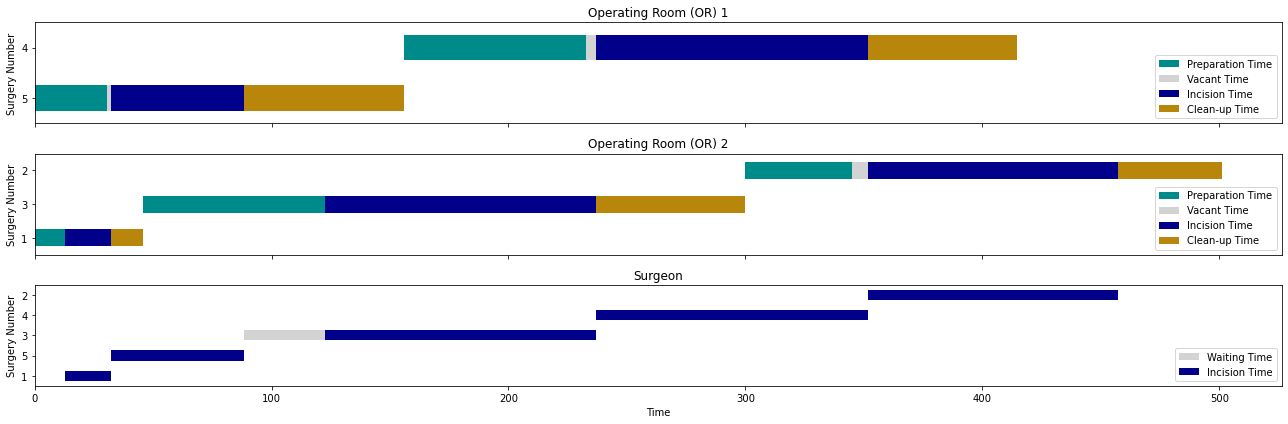

In [102]:
#Overiew of the surgery location
headers_sur_tab_wor_P2 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_wor_P2 = pd.DataFrame(columns = headers_sur_tab_wor_P2)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_wor_P2.loc[len(result_sur_tab_wor_P2),headers_sur_tab_wor_P2[h]] = s
    s+=1
    h+=1
    result_sur_tab_wor_P2.loc[len(result_sur_tab_wor_P2)-1,headers_sur_tab_wor_P2[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_wor_P2.loc[len(result_sur_tab_wor_P2)-1,headers_sur_tab_wor_P2[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_wor_P2 = result_sur_tab_wor_P2.loc[result_sur_tab_wor_P2["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_wor_P2["Surgery Number"].tolist()):
    result_OR1_tab_wor_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_wor_P2["Surgery Number"].tolist():
    result_OR1_tab_wor_P2["Order"] = result_OR1_tab_wor_P2["Beginning of Incision Time"].rank()
result_OR1_tab_wor_P2.sort_values(by="Order", inplace = True)
result_OR1_tab_wor_P2.reset_index(drop = True, inplace = True)
result_OR1_tab_wor_P2.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_wor_P2["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_wor_P2)-1:
        result_OR1_tab_wor_P2.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_wor_P2["Surgery Number"].tolist()):
    result_OR1_tab_wor_P2.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_wor_P2.loc[idx,"End of Preparation Time"] = result_OR1_tab_wor_P2.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_wor_P2.loc[idx,"Preparation Time"]
    result_OR1_tab_wor_P2.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_wor_P2.loc[idx,"End of Preparation Time"]
    result_OR1_tab_wor_P2.loc[idx,"Vacant Time"] = round(result_OR1_tab_wor_P2.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_wor_P2.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_wor_P2.loc[idx,"End of Vacant Time"] = result_OR1_tab_wor_P2.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_wor_P2.loc[idx,"Vacant Time"]
    result_OR1_tab_wor_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_wor_P2.loc[idx,"End of Incision Time"] = result_OR1_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_wor_P2.loc[idx,"Incision Time"]
    result_OR1_tab_wor_P2.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_wor_P2.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_wor_P2.loc[idx,"End of Clean-up Time"] = result_OR1_tab_wor_P2.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_wor_P2.loc[idx,"Clean-up Time"]
result_OR1_tab_wor_P2 = result_OR1_tab_wor_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_wor_P2["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_wor_P2.loc[len(result_OR1_tab_wor_P2)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_wor_P2["Maximum Normal Shift Time"] = ""
result_OR1_tab_wor_P2.loc[len(result_OR1_tab_wor_P2)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_wor_P2["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_wor_P2.loc[len(result_OR1_tab_wor_P2)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_wor_P2 = result_OR1_tab_wor_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_wor_P2 = result_sur_tab_wor_P2.loc[result_sur_tab_wor_P2["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_wor_P2["Surgery Number"].tolist()):
    result_OR2_tab_wor_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_wor_P2["Surgery Number"].tolist():
    result_OR2_tab_wor_P2["Order"] = result_OR2_tab_wor_P2["Beginning of Incision Time"].rank()
result_OR2_tab_wor_P2.sort_values(by="Order", inplace = True)
result_OR2_tab_wor_P2.reset_index(drop = True, inplace = True)
result_OR2_tab_wor_P2.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_wor_P2["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_wor_P2)-1:
        result_OR2_tab_wor_P2.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_wor_P2["Surgery Number"].tolist()):
    result_OR2_tab_wor_P2.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_wor_P2.loc[idx,"End of Preparation Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_wor_P2.loc[idx,"Preparation Time"]
    result_OR2_tab_wor_P2.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_wor_P2.loc[idx,"End of Preparation Time"]
    result_OR2_tab_wor_P2.loc[idx,"Vacant Time"] = round(result_OR2_tab_wor_P2.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_wor_P2.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_wor_P2.loc[idx,"End of Vacant Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_wor_P2.loc[idx,"Vacant Time"]
    result_OR2_tab_wor_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_wor_P2.loc[idx,"End of Incision Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_wor_P2.loc[idx,"Incision Time"]
    result_OR2_tab_wor_P2.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_wor_P2.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_wor_P2.loc[idx,"End of Clean-up Time"] = result_OR2_tab_wor_P2.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_wor_P2.loc[idx,"Clean-up Time"]
result_OR2_tab_wor_P2["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_wor_P2.loc[len(result_OR2_tab_wor_P2)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_wor_P2["Maximum Normal Shift Time"] = ""
result_OR2_tab_wor_P2.loc[len(result_OR2_tab_wor_P2)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_wor_P2["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_wor_P2.loc[len(result_OR2_tab_wor_P2)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_wor_P2 = result_OR2_tab_wor_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_wor_P2 = result_sur_tab_wor_P2.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_wor_P2["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P2.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_wor_P2["Surgery Number"].tolist():
    result_surgeons_tab_wor_P2["Order"] = result_surgeons_tab_wor_P2["Beginning of Incision Time"].rank()
result_surgeons_tab_wor_P2.sort_values(by="Order", inplace = True)
result_surgeons_tab_wor_P2.reset_index(drop = True, inplace = True)
result_surgeons_tab_wor_P2["Start Time of Surgeon"] = 0
result_surgeons_tab_wor_P2.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_wor_P2.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P2["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P2)-1:
        result_surgeons_tab_wor_P2.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_wor_P2.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P2["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P2)-1:
        result_surgeons_tab_wor_P2.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_wor_P2.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_wor_P2.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_wor_P2["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P2.loc[idx,"End of Waiting Time"] = result_surgeons_tab_wor_P2.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_wor_P2.loc[idx,"Waiting Time"]
    result_surgeons_tab_wor_P2.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_wor_P2.loc[idx,"End of Incision Time"] = result_surgeons_tab_wor_P2.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_wor_P2.loc[idx,"Incision Time"]
result_surgeons_tab_wor_P2 = result_surgeons_tab_wor_P2.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_wor_P2 = result_sur_tab_wor_P2.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_wor_P2 = result_OR1_tab_wor_P2.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_wor_P2 = result_OR2_tab_wor_P2.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_wor_P2 = result_surgeons_tab_wor_P2.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_wor_P2 = headers_cost_tab_wor_P2 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_wor_P2 = pd.DataFrame(columns = headers_cost_tab_wor_P2)
h=0
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2), headers_cost_tab_wor_P2[h]] = O[1].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = O[2].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = co/60
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = VT[1].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = VT[2].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = cv/60
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = WT.solution_value
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = cw/60
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, headers_cost_tab_wor_P2[h]] = result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, "Total OR Vacant Time Cost"]+result_cost_tab_wor_P2.loc[len(result_cost_tab_wor_P2)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_wor_P2, (result_OR1_plot_wor_P2, result_OR2_plot_wor_P2, result_surgeons_plot_wor_P2) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_wor_P2 = result_OR1_tab_wor_P2.plot.barh(ax = result_OR1_plot_wor_P2, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_wor_P2.set_xlabel("Time")
result_OR1_plot_wor_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_wor_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_wor_P2 = result_OR2_tab_wor_P2.plot.barh(ax = result_OR2_plot_wor_P2, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_wor_P2.set_xlabel("Time")
result_OR2_plot_wor_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_wor_P2.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_wor_P2 = result_surgeons_tab_wor_P2.plot.barh(ax = result_surgeons_plot_wor_P2, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_wor_P2.set_xlabel("Time")
result_surgeons_plot_wor_P2.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_wor_P2.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [103]:
print(result_sur_tab_wor_P2)
print(result_OR1_tab_wor_P2)
print(result_OR2_tab_wor_P2)
print(result_surgeons_tab_wor_P2)
print(result_cost_tab_wor_P2)

               Surgery Type Location
Surgery Number                      
1                         A     OR 2
2                         D     OR 2
3                         G     OR 2
4                         G     OR 1
5                         J     OR 1
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
5                                J    1.0                            0.0   
4                                G    2.0                          156.1   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
5                                  30.6                     30.6   
4                                  76.5                    232.6   

                       Beginning of Vacant Time  Vacant Time  \
Surgery Number | OR 1                                          
5                                  

##### Export the results

In [104]:
with pd.ExcelWriter("SurgeryScheduling_Worst_P2.xlsx") as writer:
    result_sur_tab_wor_P2.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_wor_P2.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_wor_P2.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_wor_P2.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_wor_P2.to_excel(writer, sheet_name = "Cost")   

In [105]:
figure_wor_P2.savefig("Timeline_Worst_P2.pdf", bbox_inches="tight")
figure_wor_P2.savefig("Timeline_Worst_P2.png", bbox_inches="tight")

#### Problem Instance 2 (Comparison of Scenarios Case, Mean Case and Worst Case)

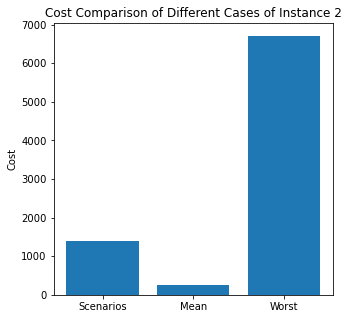

In [106]:
#Objective value comparison
x_comp_P2 = ["Scenarios", "Mean", "Worst"]
y_comp_P2 = [model_stoc_P2.objective_value, model_P2.objective_value, model_wor_P2.objective_value]
cost_plot_comp_P2 = plt.figure(figsize = (5,5))
plt.bar(x_comp_P2, y_comp_P2)
plt.ylabel("Cost")
plt.title("Cost Comparison of Different Cases of Instance 2")

#Location and sequence comparison
result_OR1_tab_P2["Location"] = "OR 1"
result_OR1_tab_P2 = result_OR1_tab_P2.reset_index()
result_OR1_tab_P2.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_P2["Location"] = "OR 2"
result_OR2_tab_P2 = result_OR2_tab_P2.reset_index()
result_OR2_tab_P2.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_mean_P2 = pd.concat([result_OR1_tab_P2, result_OR2_tab_P2])
result_all_tab_mean_P2.rename(columns = {"Surgery Number":"Surgery Number | Mean Case"}, inplace = True)
result_all_tab_mean_P2 = result_all_tab_mean_P2.reindex(columns = ["Surgery Number | Mean Case","Surgery Type","Location","Order"])
result_all_tab_mean_P2 = result_all_tab_mean_P2.reset_index(drop = True)

result_OR1_tab_wor_P2["Location"] = "OR 1"
result_OR1_tab_wor_P2 = result_OR1_tab_wor_P2.reset_index()
result_OR1_tab_wor_P2.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_wor_P2["Location"] = "OR 2"
result_OR2_tab_wor_P2 = result_OR2_tab_wor_P2.reset_index()
result_OR2_tab_wor_P2.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_wor_P2 = pd.concat([result_OR1_tab_wor_P2, result_OR2_tab_wor_P2])
result_all_tab_wor_P2.rename(columns = {"Surgery Number":"Surgery Number | Worst Case"}, inplace = True)
result_all_tab_wor_P2 = result_all_tab_wor_P2.reindex(columns = ["Surgery Number | Worst Case","Surgery Type","Location","Order"])
result_all_tab_wor_P2 = result_all_tab_wor_P2.reset_index(drop = True)

result_sur_tab_stoc_P2 = result_sur_tab_stoc_P2.reset_index()
result_sur_tab_stoc_P2.rename(columns = {"Surgery Number":"Surgery Number | Scenarios Case"}, inplace = True)

result_all_sur_tab_stoc_P2 = pd.concat([result_sur_tab_stoc_P2,result_all_tab_mean_P2,result_all_tab_wor_P2], axis = 1)


##### Export the results

In [107]:
with pd.ExcelWriter("SurgeryScheduling_Comp_P2.xlsx") as writer:
    result_all_sur_tab_stoc_P2.to_excel(writer, sheet_name = "Cases Comparison_P2")

cost_plot_comp_P2.savefig("CostComparison_P2.pdf", bbox_inches="tight")
cost_plot_comp_P2.savefig("CostComparison_P2.png", bbox_inches="tight")

#### Problem Instance 3

##### Create the model instance

In [108]:
model_stoc_P3 = Model("SurgerySchedulingStochastic_P3")

##### Define all sets

In [109]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

scenarios = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A", nrows = 100, skiprows = 2)
scenarios = scenarios.index.tolist()
scenarios = [1]+[i+2 for i in scenarios]
scenarios_fin = ["s"+str(i) for i in scenarios] #100 different scenarios with different preparation time, incision time and clean-up time
prob_s = (max(scenarios)/len(scenarios))/100 #Probability of each scenario is assumed to be equal

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 4)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 3)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:J", nrows = 1, skiprows = 3)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp["Scenarios"] = scenarios_fin
tp = tp.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Preparation time of each surgery type in different scenarios (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts.columns = tp.columns
ts["Scenarios"] = scenarios_fin
ts = ts.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Incision time of each surgery type in different scenarios (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc.columns = tp.columns
tc["Scenarios"] = scenarios_fin
tc = tc.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Clean-up time of each surgery type in different scenarios (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [110]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
480
[1, 2, 3, 4, 5, 6, 7]
['A', 'B', 'D', 'E', 'G', 'G', 'J']
{1: 'A', 2: 'B', 3: 'D', 4: 'E', 5: 'G', 6: 'G', 7: 'J'}
                             A     B     C     D     E     F     G     H  \
Scenarios | Surgery Type                                                   
s1                        11.8  29.7  29.0  28.3  79.0  37.4  28.7  30.3   
s2                         2.2  43.0  34.4  13.9  31.0  27.3  31.4  15.1   
s3                         4.1  80.4  36.9  15.1  78.8  45.6  25.2  16.3   
s4                         4.6  37.1  21.2  23.8  27.5  21.0  62.2  21.3   
s5                         6.2  40.8  37.4   9.7  25.6  36.9  21.3  20.9   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
s96                        5.8  26.1  22.9   8.7  72.2  47.3  41.6  15.1   
s97                        9.9  34.7  22.2  12.7  60.3  23.6  45.2  28.2   
s98                        9.0  41.8  21.3  16.6  45.7  43.9  22.4  26.6   
s99                        5.0  28.5  

##### Define the decision variables

In [111]:
X = model_stoc_P3.continuous_var_matrix(surgery, scenarios_fin, name = "start_sur") #Start time of the incision of surgery i in scenario s (in min)
SMS = model_stoc_P3.continuous_var_dict(scenarios_fin, name = "surgeon_makespan") #Time when surgeon finishes last incision in scenario s (in min)
WT = model_stoc_P3.continuous_var_dict(scenarios_fin, name = "surgeon_wait") #Surgeon's total waiting time within the whole shift in scenario s (in min)
Y = model_stoc_P3.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_stoc_P3.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_stoc_P3.continuous_var_matrix(rooms, scenarios_fin, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up in scenario s (in min)
VT = model_stoc_P3.continuous_var_matrix(rooms, scenarios_fin, name = "OR_vacant") #OR's total vacant time within the whole shift in scenario s (in min)
O = model_stoc_P3.continuous_var_matrix(rooms, scenarios_fin, name = "OR_ot") #OR staff overtime in OR r in scenario s (in min)
F = model_stoc_P3.continuous_var_matrix(rooms, scenarios_fin, name = "Or_unused") #OR r's unused normal shift time in scenario s (in min)
S = model_stoc_P3.continuous_var_dict(scenarios_fin, name = "surgeon_begin") #Start time of the surgeon in his first surgery in scenario s (in min)

##### Define all constraints

In [112]:
#The earliest start time of a surgery incision
model_stoc_P3.add_constraints(X[i,s] >= tp.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_stoc_P3.add_constraints(S[s] <= X[i,s] for s in scenarios_fin for i in surgery) #The start time of the surgeon
model_stoc_P3.add_constraints(SMS[s] >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The latest incision finishing time
model_stoc_P3.add_constraints(WT[s] == SMS[s]-model_stoc_P3.sum(ts.loc[s,sur_type[i]] for i in surgery)-S[s] for s in scenarios_fin) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_stoc_P3.add_constraints(X[j,s]+big_M*(1-Y[i,j]) >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_stoc_P3.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_stoc_P3.add_constraints(ORMS[r,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+(W[i,r]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery) #The latest clean-up finishing time
model_stoc_P3.add_constraints(ORMS[r,s] == T+O[r,s]-F[r,s] for s in scenarios_fin for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_stoc_P3.add_constraints(VT[r,s] == ORMS[r,s]-model_stoc_P3.sum(W[i,r]*(tp.loc[s,sur_type[i]]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]) for i in surgery) for s in scenarios_fin for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_stoc_P3.add_constraints(X[j,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+tp.loc[s,sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_stoc_P3.add_constraints(model_stoc_P3.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1)]

##### Define linear expression

In [113]:
J = model_stoc_P3.sum((prob_s*(model_stoc_P3.sum(((O[r,s]/60)*co) for r in rooms))) for s in scenarios_fin)+model_stoc_P3.sum((prob_s*(model_stoc_P3.sum(((VT[r,s]/60)*cv) for r in rooms))) for s in scenarios_fin)+model_stoc_P3.sum((prob_s*((WT[s]/60)*cw)) for s in scenarios_fin)

##### Define the objective function

In [114]:
model_stoc_P3.minimize(J)

##### Solve the model

In [115]:
model_stoc_P3.solve()

docplex.mp.solution.SolveSolution(obj=2810.36,values={start_sur_1_s1:25,..

In [116]:
print(model_stoc_P3.solve_details)
print(model_stoc_P3.report())
print(model_stoc_P3.print_information())
print(model_stoc_P3.print_solution())
print(model_stoc_P3.get_solve_status())
print(model_stoc_P3.solve_details.time)

status  = integer optimal solution
time    = 183.187 s.
problem = MILP
gap     = 0%

* model SurgerySchedulingStochastic_P3 solved with objective = 2810.359
None
Model: SurgerySchedulingStochastic_P3
 - number of variables: 1863
   - binary=63, integer=0, continuous=1800
 - number of constraints: 16649
   - linear=16649
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
None
objective: 2810.359
  start_sur_1_s1=25.000
  start_sur_1_s2=2.200
  start_sur_1_s3=5.600
  start_sur_1_s4=19.000
  start_sur_1_s5=6.200
  start_sur_1_s6=2.100
  start_sur_1_s7=6.700
  start_sur_1_s8=4.800
  start_sur_1_s9=10.000
  start_sur_1_s10=7.100
  start_sur_1_s11=9.000
  start_sur_1_s12=5.700
  start_sur_1_s13=5.600
  start_sur_1_s14=1.800
  start_sur_1_s15=2.900
  start_sur_1_s16=4.600
  start_sur_1_s17=3.300
  start_sur_1_s18=8.000
  start_sur_1_s19=5.000
  start_sur_1_s20=3.800
  start_sur_1_s21=11.100
  start_sur_1_s22=6.900
  start_sur_1_s23=6.000
  start_sur_1_s24=6.300
  start_su

##### Store the results

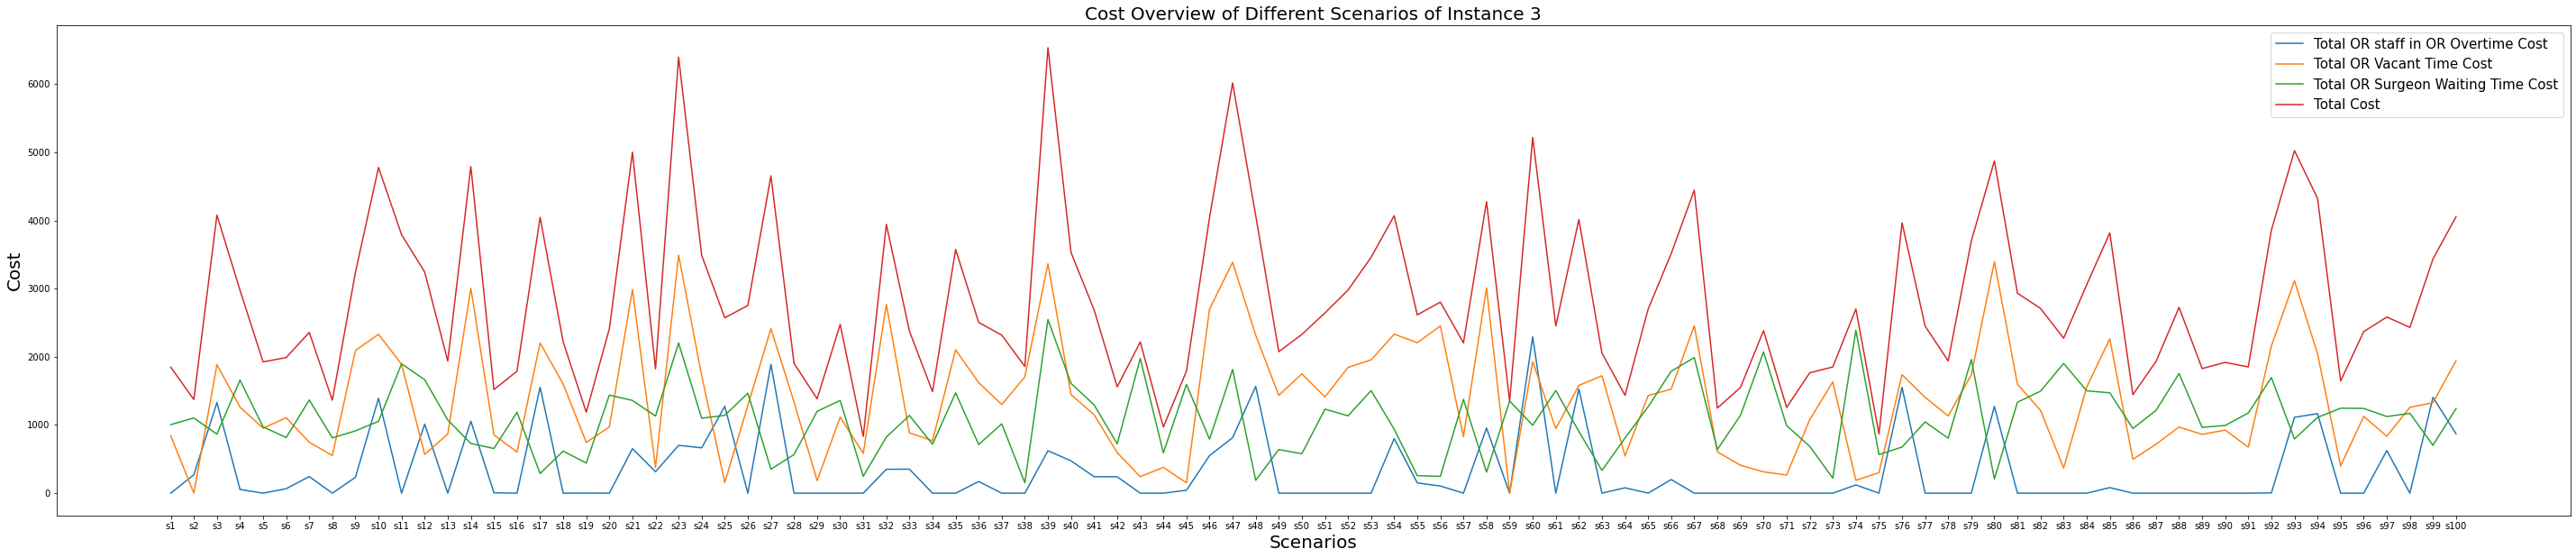

In [117]:
#Overiew of the surgery location and sequence
sur_seq_tab_stoc_P3 = pd.DataFrame(index = [i for i in surgery], columns = [j for j in surgery])
for i in surgery:
    for j in surgery:
        sur_seq_tab_stoc_P3.loc[i,j] = Y[i,j].solution_value
sur_seq_tab_stoc_P3["Indicator for Ranking"] = sur_seq_tab_stoc_P3.sum(axis = 1).astype(int)
for i in surgery:
    for r in rooms:
        if W[i,r].solution_value == 1:
            sur_seq_tab_stoc_P3.loc[i,"Location"] = "OR "+ str(r)
sur_OR1_seq_tab_stoc_P3 = sur_seq_tab_stoc_P3.loc[sur_seq_tab_stoc_P3["Location"]=="OR 1"].copy(deep = True)
for i in range(len(sur_OR1_seq_tab_stoc_P3.index.tolist())):
    sur_OR1_seq_tab_stoc_P3["Order"] = sur_OR1_seq_tab_stoc_P3["Indicator for Ranking"].rank(ascending = False)
sur_OR2_seq_tab_stoc_P3 = sur_seq_tab_stoc_P3.loc[sur_seq_tab_stoc_P3["Location"]=="OR 2"].copy(deep = True)
for i in range(len(sur_OR2_seq_tab_stoc_P3.index.tolist())):
    sur_OR2_seq_tab_stoc_P3["Order"] = sur_OR2_seq_tab_stoc_P3["Indicator for Ranking"].rank(ascending = False)
sur_all_seq_tab_stoc_P3 = pd.concat([sur_OR1_seq_tab_stoc_P3,sur_OR2_seq_tab_stoc_P3])
        
headers_sur_tab_stoc_P3 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_stoc_P3 = pd.DataFrame(columns = headers_sur_tab_stoc_P3)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_stoc_P3.loc[len(result_sur_tab_stoc_P3),headers_sur_tab_stoc_P3[h]] = s
    s+=1
    h+=1
    result_sur_tab_stoc_P3.loc[len(result_sur_tab_stoc_P3)-1,headers_sur_tab_stoc_P3[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_stoc_P3.loc[len(result_sur_tab_stoc_P3)-1,headers_sur_tab_stoc_P3[h]] = "OR "+ str(r)
result_sur_tab_stoc_P3 = result_sur_tab_stoc_P3.set_index("Surgery Number")
for i in surgery:
    result_sur_tab_stoc_P3.loc[i, "Order"] = sur_all_seq_tab_stoc_P3.loc[i, "Order"]
result_sur_tab_stoc_P3 = result_sur_tab_stoc_P3.sort_values("Location")

#Overview of cost in different scenarios
headers_cost_tab_stoc_P3 = headers_cost_tab_stoc_P3 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_stoc_P3 = pd.DataFrame(columns = headers_cost_tab_stoc_P3)
for s in scenarios_fin:
    h=0
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3), headers_cost_tab_stoc_P3[h]] = O[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = O[1,s].solution_value+O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = co/60
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = (O[1,s].solution_value+O[2,s].solution_value)*(co/60)
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = VT[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = VT[1,s].solution_value+VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = cv/60
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = (VT[1,s].solution_value+VT[2,s].solution_value)*(cv/60)
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = WT[s].solution_value
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = cw/60
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = WT[s].solution_value*(cw/60)
    h+=1
    result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, headers_cost_tab_stoc_P3[h]] = result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, "Total OR Vacant Time Cost"]+result_cost_tab_stoc_P3.loc[len(result_cost_tab_stoc_P3)-1, "Total OR Surgeon Waiting Time Cost"]
result_cost_tab_stoc_P3["Scenarios"] = scenarios_fin
result_cost_tab_stoc_P3 = result_cost_tab_stoc_P3.set_index("Scenarios")

#Overview of cost in different scenarios in graph
cost_plot_stoc_P3 = plt.figure(figsize = (50,10))
plt.plot(result_cost_tab_stoc_P3.index,result_cost_tab_stoc_P3["Total OR staff in OR Overtime Cost"], label = "Total OR staff in OR Overtime Cost")
plt.plot(result_cost_tab_stoc_P3.index,result_cost_tab_stoc_P3["Total OR Vacant Time Cost"], label = "Total OR Vacant Time Cost")
plt.plot(result_cost_tab_stoc_P3.index,result_cost_tab_stoc_P3["Total OR Surgeon Waiting Time Cost"], label = "Total OR Surgeon Waiting Time Cost")
plt.plot(result_cost_tab_stoc_P3.index,result_cost_tab_stoc_P3["Total Cost"], label = "Total Cost")
plt.xlabel("Scenarios", fontsize = 20)
plt.ylabel("Cost", fontsize = 20)
plt.title("Cost Overview of Different Scenarios of Instance 3", fontsize = 20)
plt.legend(fontsize = 15)

##### Export the results

In [118]:
with pd.ExcelWriter("SurgerySchedulingStoc_P3.xlsx") as writer:
    result_cost_tab_stoc_P3.to_excel(writer, sheet_name = "Cost") 
    
cost_plot_stoc_P3.savefig("Stochastic_Cost_P3.pdf", bbox_inches="tight")
cost_plot_stoc_P3.savefig("Stochastic_Cost_P3.png", bbox_inches="tight")

#### Problem Instance 3 (Worst Case Scenario)

##### Create the model instance

In [119]:
model_wor_P3 = Model("SurgeryScheduling_wor_P3")

##### Define all sets

In [120]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 4)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 3)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:J", nrows = 1, skiprows = 3)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.max(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.max(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.max(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [121]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
480
[1, 2, 3, 4, 5, 6, 7]
['A', 'B', 'D', 'E', 'G', 'G', 'J']
{1: 'A', 2: 'B', 3: 'D', 4: 'E', 5: 'G', 6: 'G', 7: 'J'}
{'A': 13.0, 'B': 80.4, 'C': 50.8, 'D': 45.1, 'E': 116.0, 'F': 56.7, 'G': 76.5, 'H': 37.8, 'I': 257.1, 'J': 30.6}
{'A': 19.4, 'B': 163.1, 'C': 139.3, 'D': 105.5, 'E': 289.1, 'F': 112.0, 'G': 114.6, 'H': 81.9, 'I': 346.5, 'J': 56.0}
{'A': 13.5, 'B': 91.8, 'C': 90.0, 'D': 44.1, 'E': 121.9, 'F': 52.6, 'G': 62.8, 'H': 46.7, 'I': 120.2, 'J': 67.7}
1209.6
1048.8
806.4


##### Define the decision variables

In [122]:
X = model_wor_P3.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_wor_P3.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_wor_P3.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_wor_P3.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_wor_P3.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_wor_P3.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_wor_P3.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_wor_P3.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_wor_P3.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_wor_P3.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [123]:
#The earliest start time of a surgery incision
model_wor_P3.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_wor_P3.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_wor_P3.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_wor_P3.add_constraint(WT == SMS-model_wor_P3.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_wor_P3.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_wor_P3.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_wor_P3.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_wor_P3.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_wor_P3.add_constraints(VT[r] == ORMS[r]-model_wor_P3.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_wor_P3.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_wor_P3.add_constraints(model_wor_P3.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1)]

##### Define linear expression

In [124]:
J = model_wor_P3.sum((O[r]/60)*co for r in rooms)+model_wor_P3.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [125]:
model_wor_P3.minimize(J)

##### Solve the model

In [126]:
model_wor_P3.solve()

docplex.mp.solution.SolveSolution(obj=13500.9,values={start_sur_1:13,sta..

In [127]:
model_wor_P3.solve_details
model_wor_P3.report()
model_wor_P3.print_information()
model_wor_P3.print_solution()
model_wor_P3.get_solve_status()

* model SurgeryScheduling_wor_P3 solved with objective = 13500.884
Model: SurgeryScheduling_wor_P3
 - number of variables: 81
   - binary=63, integer=0, continuous=18
 - number of constraints: 215
   - linear=215
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 13500.884
  start_sur_1=13.000
  start_sur_2=490.400
  start_sur_3=91.000
  start_sur_4=653.500
  start_sur_5=347.200
  start_sur_6=232.600
  start_sur_7=32.400
  surgeon_makespan=942.600
  surgeon_wait=67.300
  order_1_2=1
  order_1_3=1
  order_1_4=1
  order_1_5=1
  order_1_6=1
  order_1_7=1
  order_2_4=1
  order_3_2=1
  order_3_4=1
  order_3_5=1
  order_3_6=1
  order_5_2=1
  order_5_4=1
  order_6_2=1
  order_6_4=1
  order_6_5=1
  order_7_2=1
  order_7_3=1
  order_7_4=1
  order_7_5=1
  order_7_6=1
  perform_1_2=1
  perform_2_1=1
  perform_3_2=1
  perform_4_2=1
  perform_5_2=1
  perform_6_1=1
  perform_7_1=1
  OR_makespan_1=745.300
  OR_makespan_2=1064.500
  OR_vacant_1=1.800
  OR_vacant_2=43.00

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-128-6851f033ef75>:166: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_wor_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-128-6851f033ef75>:174: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_wor_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-128-6851f033ef75>:182: UserWarning: The handle <BarContainer object of 7 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_wor_P3.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


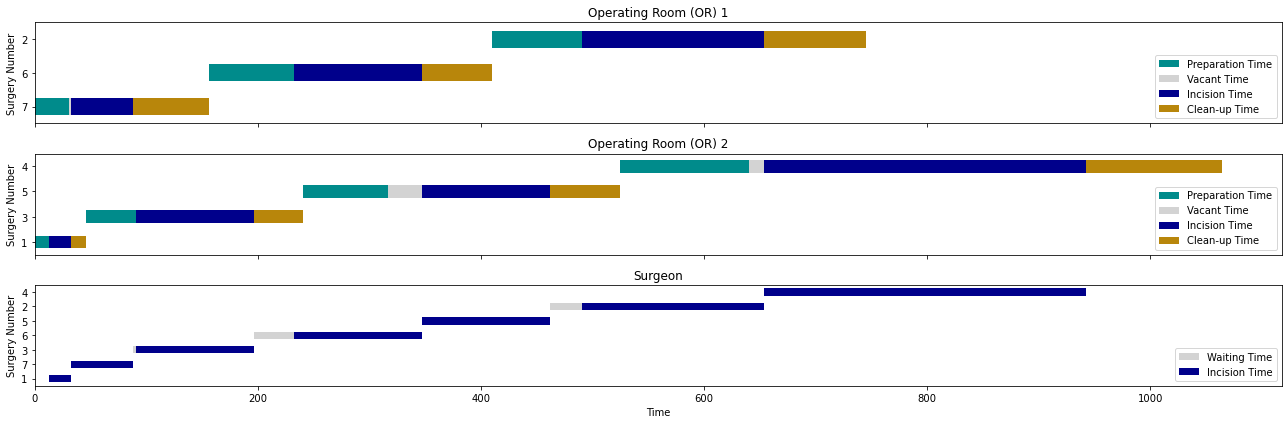

In [128]:
#Overiew of the surgery location
headers_sur_tab_wor_P3 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_wor_P3 = pd.DataFrame(columns = headers_sur_tab_wor_P3)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_wor_P3.loc[len(result_sur_tab_wor_P3),headers_sur_tab_wor_P3[h]] = s
    s+=1
    h+=1
    result_sur_tab_wor_P3.loc[len(result_sur_tab_wor_P3)-1,headers_sur_tab_wor_P3[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_wor_P3.loc[len(result_sur_tab_wor_P3)-1,headers_sur_tab_wor_P3[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_wor_P3 = result_sur_tab_wor_P3.loc[result_sur_tab_wor_P3["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_wor_P3["Surgery Number"].tolist()):
    result_OR1_tab_wor_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_wor_P3["Surgery Number"].tolist():
    result_OR1_tab_wor_P3["Order"] = result_OR1_tab_wor_P3["Beginning of Incision Time"].rank()
result_OR1_tab_wor_P3.sort_values(by="Order", inplace = True)
result_OR1_tab_wor_P3.reset_index(drop = True, inplace = True)
result_OR1_tab_wor_P3.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_wor_P3["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_wor_P3)-1:
        result_OR1_tab_wor_P3.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_wor_P3["Surgery Number"].tolist()):
    result_OR1_tab_wor_P3.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_wor_P3.loc[idx,"End of Preparation Time"] = result_OR1_tab_wor_P3.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_wor_P3.loc[idx,"Preparation Time"]
    result_OR1_tab_wor_P3.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_wor_P3.loc[idx,"End of Preparation Time"]
    result_OR1_tab_wor_P3.loc[idx,"Vacant Time"] = round(result_OR1_tab_wor_P3.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_wor_P3.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_wor_P3.loc[idx,"End of Vacant Time"] = result_OR1_tab_wor_P3.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_wor_P3.loc[idx,"Vacant Time"]
    result_OR1_tab_wor_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_wor_P3.loc[idx,"End of Incision Time"] = result_OR1_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_wor_P3.loc[idx,"Incision Time"]
    result_OR1_tab_wor_P3.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_wor_P3.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_wor_P3.loc[idx,"End of Clean-up Time"] = result_OR1_tab_wor_P3.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_wor_P3.loc[idx,"Clean-up Time"]
result_OR1_tab_wor_P3 = result_OR1_tab_wor_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_wor_P3["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_wor_P3.loc[len(result_OR1_tab_wor_P3)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_wor_P3["Maximum Normal Shift Time"] = ""
result_OR1_tab_wor_P3.loc[len(result_OR1_tab_wor_P3)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_wor_P3["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_wor_P3.loc[len(result_OR1_tab_wor_P3)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_wor_P3 = result_OR1_tab_wor_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_wor_P3 = result_sur_tab_wor_P3.loc[result_sur_tab_wor_P3["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_wor_P3["Surgery Number"].tolist()):
    result_OR2_tab_wor_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_wor_P3["Surgery Number"].tolist():
    result_OR2_tab_wor_P3["Order"] = result_OR2_tab_wor_P3["Beginning of Incision Time"].rank()
result_OR2_tab_wor_P3.sort_values(by="Order", inplace = True)
result_OR2_tab_wor_P3.reset_index(drop = True, inplace = True)
result_OR2_tab_wor_P3.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_wor_P3["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_wor_P3)-1:
        result_OR2_tab_wor_P3.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_wor_P3["Surgery Number"].tolist()):
    result_OR2_tab_wor_P3.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_wor_P3.loc[idx,"End of Preparation Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_wor_P3.loc[idx,"Preparation Time"]
    result_OR2_tab_wor_P3.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_wor_P3.loc[idx,"End of Preparation Time"]
    result_OR2_tab_wor_P3.loc[idx,"Vacant Time"] = round(result_OR2_tab_wor_P3.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_wor_P3.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_wor_P3.loc[idx,"End of Vacant Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_wor_P3.loc[idx,"Vacant Time"]
    result_OR2_tab_wor_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_wor_P3.loc[idx,"End of Incision Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_wor_P3.loc[idx,"Incision Time"]
    result_OR2_tab_wor_P3.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_wor_P3.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_wor_P3.loc[idx,"End of Clean-up Time"] = result_OR2_tab_wor_P3.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_wor_P3.loc[idx,"Clean-up Time"]
result_OR2_tab_wor_P3["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_wor_P3.loc[len(result_OR2_tab_wor_P3)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_wor_P3["Maximum Normal Shift Time"] = ""
result_OR2_tab_wor_P3.loc[len(result_OR2_tab_wor_P3)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_wor_P3["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_wor_P3.loc[len(result_OR2_tab_wor_P3)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_wor_P3 = result_OR2_tab_wor_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_wor_P3 = result_sur_tab_wor_P3.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_wor_P3["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P3.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_wor_P3["Surgery Number"].tolist():
    result_surgeons_tab_wor_P3["Order"] = result_surgeons_tab_wor_P3["Beginning of Incision Time"].rank()
result_surgeons_tab_wor_P3.sort_values(by="Order", inplace = True)
result_surgeons_tab_wor_P3.reset_index(drop = True, inplace = True)
result_surgeons_tab_wor_P3["Start Time of Surgeon"] = 0
result_surgeons_tab_wor_P3.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_wor_P3.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P3["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P3)-1:
        result_surgeons_tab_wor_P3.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_wor_P3.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P3["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P3)-1:
        result_surgeons_tab_wor_P3.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_wor_P3.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_wor_P3.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_wor_P3["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P3.loc[idx,"End of Waiting Time"] = result_surgeons_tab_wor_P3.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_wor_P3.loc[idx,"Waiting Time"]
    result_surgeons_tab_wor_P3.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_wor_P3.loc[idx,"End of Incision Time"] = result_surgeons_tab_wor_P3.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_wor_P3.loc[idx,"Incision Time"]
result_surgeons_tab_wor_P3 = result_surgeons_tab_wor_P3.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_wor_P3 = result_sur_tab_wor_P3.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_wor_P3 = result_OR1_tab_wor_P3.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_wor_P3 = result_OR2_tab_wor_P3.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_wor_P3 = result_surgeons_tab_wor_P3.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_wor_P3 = headers_cost_tab_wor_P3 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_wor_P3 = pd.DataFrame(columns = headers_cost_tab_wor_P3)
h=0
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3), headers_cost_tab_wor_P3[h]] = O[1].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = O[2].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = co/60
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = VT[1].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = VT[2].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = cv/60
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = WT.solution_value
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = cw/60
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, headers_cost_tab_wor_P3[h]] = result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, "Total OR Vacant Time Cost"]+result_cost_tab_wor_P3.loc[len(result_cost_tab_wor_P3)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_wor_P3, (result_OR1_plot_wor_P3, result_OR2_plot_wor_P3, result_surgeons_plot_wor_P3) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_wor_P3 = result_OR1_tab_wor_P3.plot.barh(ax = result_OR1_plot_wor_P3, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_wor_P3.set_xlabel("Time")
result_OR1_plot_wor_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_wor_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_wor_P3 = result_OR2_tab_wor_P3.plot.barh(ax = result_OR2_plot_wor_P3, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_wor_P3.set_xlabel("Time")
result_OR2_plot_wor_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_wor_P3.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_wor_P3 = result_surgeons_tab_wor_P3.plot.barh(ax = result_surgeons_plot_wor_P3, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_wor_P3.set_xlabel("Time")
result_surgeons_plot_wor_P3.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_wor_P3.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [129]:
print(result_sur_tab_wor_P3)
print(result_OR1_tab_wor_P3)
print(result_OR2_tab_wor_P3)
print(result_surgeons_tab_wor_P3)
print(result_cost_tab_wor_P3)

               Surgery Type Location
Surgery Number                      
1                         A     OR 2
2                         B     OR 1
3                         D     OR 2
4                         E     OR 2
5                         G     OR 2
6                         G     OR 1
7                         J     OR 1
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
7                                J    1.0                            0.0   
6                                G    2.0                          156.1   
2                                B    3.0                          410.0   

                       Preparation Time  End of Preparation Time  \
Surgery Number | OR 1                                              
7                                  30.6                     30.6   
6                                  76.5                    232.6   
2             

##### Export the results

In [130]:
with pd.ExcelWriter("SurgeryScheduling_Worst_P3.xlsx") as writer:
    result_sur_tab_wor_P3.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_wor_P3.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_wor_P3.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_wor_P3.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_wor_P3.to_excel(writer, sheet_name = "Cost")   

In [131]:
figure_wor_P3.savefig("Timeline_Worst_P3.pdf", bbox_inches="tight")
figure_wor_P3.savefig("Timeline_Worst_P3.png", bbox_inches="tight")

#### Problem Instance 3 (Comparison of Scenarios Case, Mean Case and Worst Case)

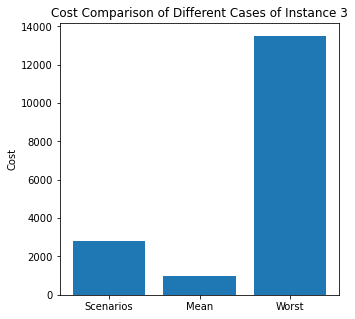

In [132]:
#Objective value comparison
x_comp_P3 = ["Scenarios", "Mean", "Worst"]
y_comp_P3 = [model_stoc_P3.objective_value, model_P3.objective_value, model_wor_P3.objective_value]
cost_plot_comp_P3 = plt.figure(figsize = (5,5))
plt.bar(x_comp_P3, y_comp_P3)
plt.ylabel("Cost")
plt.title("Cost Comparison of Different Cases of Instance 3")

#Location and sequence comparison
result_OR1_tab_P3["Location"] = "OR 1"
result_OR1_tab_P3 = result_OR1_tab_P3.reset_index()
result_OR1_tab_P3.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_P3["Location"] = "OR 2"
result_OR2_tab_P3 = result_OR2_tab_P3.reset_index()
result_OR2_tab_P3.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_mean_P3 = pd.concat([result_OR1_tab_P3, result_OR2_tab_P3])
result_all_tab_mean_P3.rename(columns = {"Surgery Number":"Surgery Number | Mean Case"}, inplace = True)
result_all_tab_mean_P3 = result_all_tab_mean_P3.reindex(columns = ["Surgery Number | Mean Case","Surgery Type","Location","Order"])
result_all_tab_mean_P3 = result_all_tab_mean_P3.reset_index(drop = True)

result_OR1_tab_wor_P3["Location"] = "OR 1"
result_OR1_tab_wor_P3 = result_OR1_tab_wor_P3.reset_index()
result_OR1_tab_wor_P3.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_wor_P3["Location"] = "OR 2"
result_OR2_tab_wor_P3 = result_OR2_tab_wor_P3.reset_index()
result_OR2_tab_wor_P3.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_wor_P3 = pd.concat([result_OR1_tab_wor_P3, result_OR2_tab_wor_P3])
result_all_tab_wor_P3.rename(columns = {"Surgery Number":"Surgery Number | Worst Case"}, inplace = True)
result_all_tab_wor_P3 = result_all_tab_wor_P3.reindex(columns = ["Surgery Number | Worst Case","Surgery Type","Location","Order"])
result_all_tab_wor_P3 = result_all_tab_wor_P3.reset_index(drop = True)

result_sur_tab_stoc_P3 = result_sur_tab_stoc_P3.reset_index()
result_sur_tab_stoc_P3.rename(columns = {"Surgery Number":"Surgery Number | Scenarios Case"}, inplace = True)

result_all_sur_tab_stoc_P3 = pd.concat([result_sur_tab_stoc_P3,result_all_tab_mean_P3,result_all_tab_wor_P3], axis = 1)


##### Export the results

In [133]:
with pd.ExcelWriter("SurgeryScheduling_Comp_P3.xlsx") as writer:
    result_all_sur_tab_stoc_P3.to_excel(writer, sheet_name = "Cases Comparison_P3")

cost_plot_comp_P3.savefig("CostComparison_P3.pdf", bbox_inches="tight")
cost_plot_comp_P3.savefig("CostComparison_P3.png", bbox_inches="tight")

#### Problem Instance 4

##### Create the model instance

In [134]:
model_stoc_P4 = Model("SurgerySchedulingStochastic_P4")

##### Define all sets

In [135]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

scenarios = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A", nrows = 100, skiprows = 2)
scenarios = scenarios.index.tolist()
scenarios = [1]+[i+2 for i in scenarios]
scenarios_fin = ["s"+str(i) for i in scenarios] #100 different scenarios with different preparation time, incision time and clean-up time
prob_s = (max(scenarios)/len(scenarios))/100 #Probability of each scenario is assumed to be equal

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 5)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 4)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:N", nrows = 1, skiprows = 4)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp["Scenarios"] = scenarios_fin
tp = tp.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Preparation time of each surgery type in different scenarios (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts.columns = tp.columns
ts["Scenarios"] = scenarios_fin
ts = ts.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Incision time of each surgery type in different scenarios (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc.columns = tp.columns
tc["Scenarios"] = scenarios_fin
tc = tc.set_index("Scenarios").rename_axis("Scenarios | Surgery Type") #Clean-up time of each surgery type in different scenarios (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [136]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
720
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['A', 'A', 'C', 'E', 'E', 'F', 'G', 'H', 'I', 'I', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'E', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'I', 11: 'J'}
                             A     B     C     D     E     F     G     H  \
Scenarios | Surgery Type                                                   
s1                        11.8  29.7  29.0  28.3  79.0  37.4  28.7  30.3   
s2                         2.2  43.0  34.4  13.9  31.0  27.3  31.4  15.1   
s3                         4.1  80.4  36.9  15.1  78.8  45.6  25.2  16.3   
s4                         4.6  37.1  21.2  23.8  27.5  21.0  62.2  21.3   
s5                         6.2  40.8  37.4   9.7  25.6  36.9  21.3  20.9   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
s96                        5.8  26.1  22.9   8.7  72.2  47.3  41.6  15.1   
s97                        9.9  34.7  22.2  12.7  60.3  23.6  45.2  28.2   
s98                        9.0  41.8  21.3  16

##### Define the decision variables

In [137]:
X = model_stoc_P4.continuous_var_matrix(surgery, scenarios_fin, name = "start_sur") #Start time of the incision of surgery i in scenario s (in min)
SMS = model_stoc_P4.continuous_var_dict(scenarios_fin, name = "surgeon_makespan") #Time when surgeon finishes last incision in scenario s (in min)
WT = model_stoc_P4.continuous_var_dict(scenarios_fin, name = "surgeon_wait") #Surgeon's total waiting time within the whole shift in scenario s (in min)
Y = model_stoc_P4.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_stoc_P4.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_stoc_P4.continuous_var_matrix(rooms, scenarios_fin, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up in scenario s (in min)
VT = model_stoc_P4.continuous_var_matrix(rooms, scenarios_fin, name = "OR_vacant") #OR's total vacant time within the whole shift in scenario s (in min)
O = model_stoc_P4.continuous_var_matrix(rooms, scenarios_fin, name = "OR_ot") #OR staff overtime in OR r in scenario s (in min)
F = model_stoc_P4.continuous_var_matrix(rooms, scenarios_fin, name = "Or_unused") #OR r's unused normal shift time in scenario s (in min)
S = model_stoc_P4.continuous_var_dict(scenarios_fin, name = "surgeon_begin") #Start time of the surgeon in his first surgery in scenario s (in min)

##### Define all constraints

In [138]:
#The earliest start time of a surgery incision
model_stoc_P4.add_constraints(X[i,s] >= tp.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_stoc_P4.add_constraints(S[s] <= X[i,s] for s in scenarios_fin for i in surgery) #The start time of the surgeon
model_stoc_P4.add_constraints(SMS[s] >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery) #The latest incision finishing time
model_stoc_P4.add_constraints(WT[s] == SMS[s]-model_stoc_P4.sum(ts.loc[s,sur_type[i]] for i in surgery)-S[s] for s in scenarios_fin) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_stoc_P4.add_constraints(X[j,s]+big_M*(1-Y[i,j]) >= X[i,s]+ts.loc[s,sur_type[i]] for s in scenarios_fin for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_stoc_P4.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_stoc_P4.add_constraints(ORMS[r,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+(W[i,r]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery) #The latest clean-up finishing time
model_stoc_P4.add_constraints(ORMS[r,s] == T+O[r,s]-F[r,s] for s in scenarios_fin for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_stoc_P4.add_constraints(VT[r,s] == ORMS[r,s]-model_stoc_P4.sum(W[i,r]*(tp.loc[s,sur_type[i]]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]) for i in surgery) for s in scenarios_fin for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_stoc_P4.add_constraints(X[j,s] >= X[i,s]+ts.loc[s,sur_type[i]]+tc.loc[s,sur_type[i]]+tp.loc[s,sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for s in scenarios_fin for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_stoc_P4.add_constraints(model_stoc_P4.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_8_1+perform_8_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_9_1+perform_9_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_10_1+perform_10_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_11_1+perform_11_2,EQ,1)]

##### Define linear expression

In [139]:
J = model_stoc_P4.sum((prob_s*(model_stoc_P4.sum(((O[r,s]/60)*co) for r in rooms))) for s in scenarios_fin)+model_stoc_P4.sum((prob_s*(model_stoc_P4.sum(((VT[r,s]/60)*cv) for r in rooms))) for s in scenarios_fin)+model_stoc_P4.sum((prob_s*((WT[s]/60)*cw)) for s in scenarios_fin)

##### Define the objective function

In [140]:
model_stoc_P4.minimize(J)

##### Solve the model

In [141]:
model_stoc_P4.set_time_limit(120)
model_stoc_P4.solve()

docplex.mp.solution.SolveSolution(obj=11531.5,values={start_sur_1_s1:11...

In [142]:
print(model_stoc_P4.solve_details)
print(model_stoc_P4.report())
print(model_stoc_P4.print_information())
print(model_stoc_P4.print_solution())
print(model_stoc_P4.solve_details.time)
print(model_stoc_P4.get_solve_status())


status  = time limit exceeded
time    = 120.187 s.
problem = MILP
gap     = 83.7673%

* model SurgerySchedulingStochastic_P4 solved with objective = 11531.512
None
Model: SurgerySchedulingStochastic_P4
 - number of variables: 2343
   - binary=143, integer=0, continuous=2200
 - number of constraints: 39121
   - linear=39121
 - parameters:
     parameters.timelimit = 120.00000000000000
 - objective: minimize
 - problem type is: MILP
None
objective: 11531.512
  start_sur_1_s1=11.800
  start_sur_1_s2=11.800
  start_sur_1_s3=8.900
  start_sur_1_s4=44.000
  start_sur_1_s5=12.100
  start_sur_1_s6=43.500
  start_sur_1_s7=6.700
  start_sur_1_s8=4.800
  start_sur_1_s9=10.200
  start_sur_1_s10=39.300
  start_sur_1_s11=16.500
  start_sur_1_s12=27.500
  start_sur_1_s13=10.900
  start_sur_1_s14=32.500
  start_sur_1_s15=19.600
  start_sur_1_s16=3.100
  start_sur_1_s17=11.400
  start_sur_1_s18=11.400
  start_sur_1_s19=5.000
  start_sur_1_s20=15.800
  start_sur_1_s21=11.100
  start_sur_1_s22=6.900
  st

##### Store the results

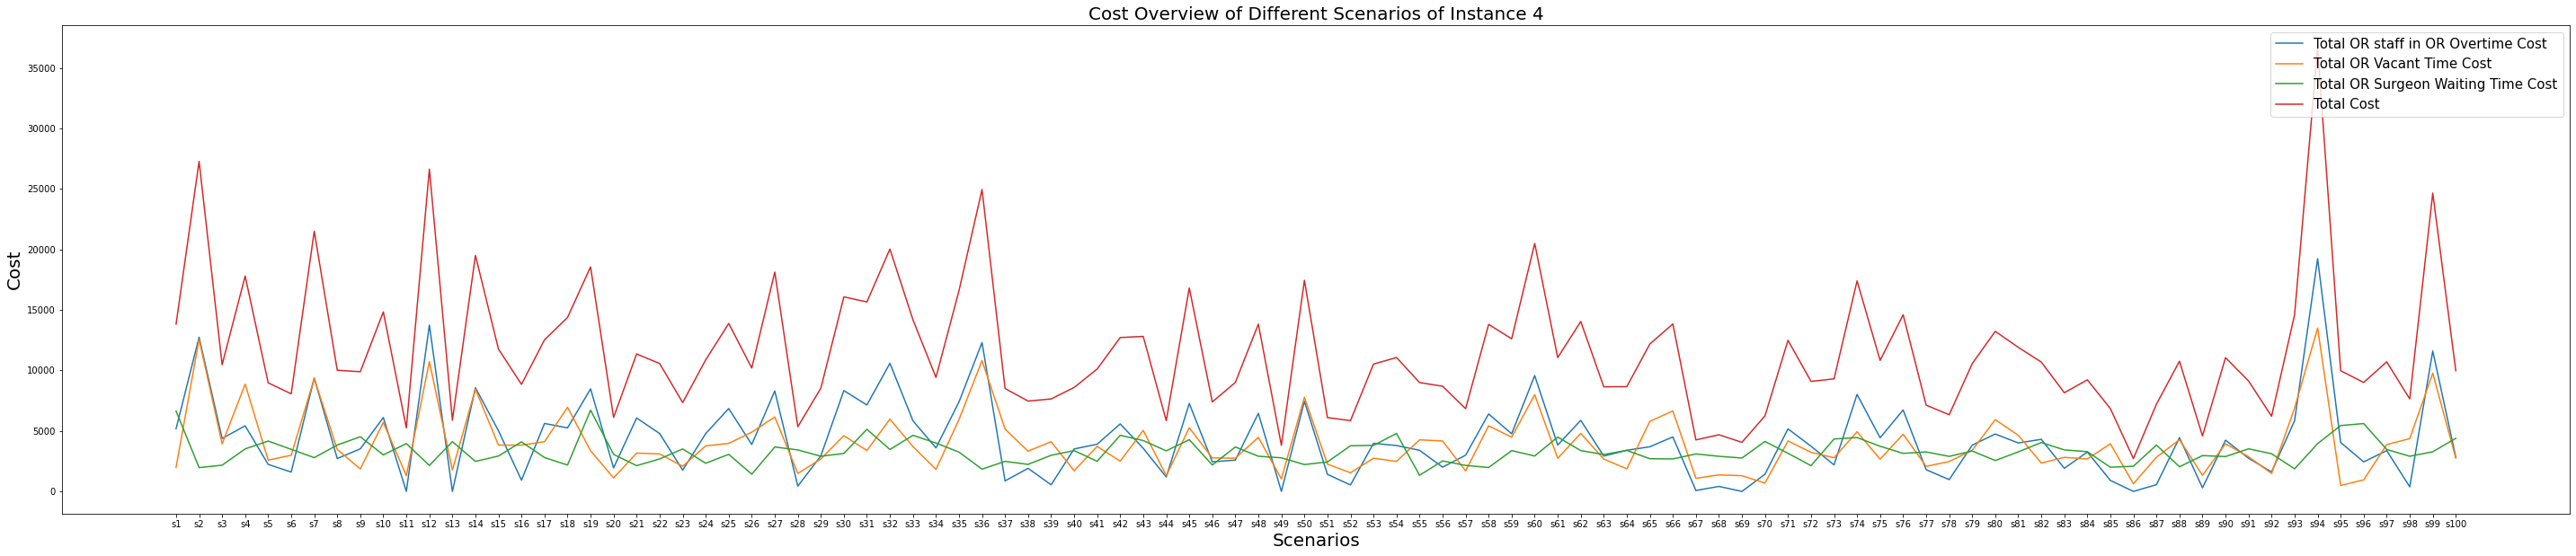

In [143]:
#Overiew of the surgery location and sequence
sur_seq_tab_stoc_P4 = pd.DataFrame(index = [i for i in surgery], columns = [j for j in surgery])
for i in surgery:
    for j in surgery:
        sur_seq_tab_stoc_P4.loc[i,j] = Y[i,j].solution_value
sur_seq_tab_stoc_P4["Indicator for Ranking"] = sur_seq_tab_stoc_P4.sum(axis = 1).astype(int)
for i in surgery:
    for r in rooms:
        if W[i,r].solution_value == 1:
            sur_seq_tab_stoc_P4.loc[i,"Location"] = "OR "+ str(r)
sur_OR1_seq_tab_stoc_P4 = sur_seq_tab_stoc_P4.loc[sur_seq_tab_stoc_P4["Location"]=="OR 1"].copy(deep = True)
for i in range(len(sur_OR1_seq_tab_stoc_P4.index.tolist())):
    sur_OR1_seq_tab_stoc_P4["Order"] = sur_OR1_seq_tab_stoc_P4["Indicator for Ranking"].rank(ascending = False)
sur_OR2_seq_tab_stoc_P4 = sur_seq_tab_stoc_P4.loc[sur_seq_tab_stoc_P4["Location"]=="OR 2"].copy(deep = True)
for i in range(len(sur_OR2_seq_tab_stoc_P4.index.tolist())):
    sur_OR2_seq_tab_stoc_P4["Order"] = sur_OR2_seq_tab_stoc_P4["Indicator for Ranking"].rank(ascending = False)
sur_all_seq_tab_stoc_P4 = pd.concat([sur_OR1_seq_tab_stoc_P4,sur_OR2_seq_tab_stoc_P4])
        
headers_sur_tab_stoc_P4 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_stoc_P4 = pd.DataFrame(columns = headers_sur_tab_stoc_P4)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_stoc_P4.loc[len(result_sur_tab_stoc_P4),headers_sur_tab_stoc_P4[h]] = s
    s+=1
    h+=1
    result_sur_tab_stoc_P4.loc[len(result_sur_tab_stoc_P4)-1,headers_sur_tab_stoc_P4[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_stoc_P4.loc[len(result_sur_tab_stoc_P4)-1,headers_sur_tab_stoc_P4[h]] = "OR "+ str(r)
result_sur_tab_stoc_P4 = result_sur_tab_stoc_P4.set_index("Surgery Number")
for i in surgery:
    result_sur_tab_stoc_P4.loc[i, "Order"] = sur_all_seq_tab_stoc_P4.loc[i, "Order"]
result_sur_tab_stoc_P4 = result_sur_tab_stoc_P4.sort_values("Location")

#Overview of cost in different scenarios
headers_cost_tab_stoc_P4 = headers_cost_tab_stoc_P4 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_stoc_P4 = pd.DataFrame(columns = headers_cost_tab_stoc_P4)
for s in scenarios_fin:
    h=0
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4), headers_cost_tab_stoc_P4[h]] = O[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = O[1,s].solution_value+O[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = co/60
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = (O[1,s].solution_value+O[2,s].solution_value)*(co/60)
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = VT[1,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = VT[1,s].solution_value+VT[2,s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = cv/60
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = (VT[1,s].solution_value+VT[2,s].solution_value)*(cv/60)
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = WT[s].solution_value
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = cw/60
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = WT[s].solution_value*(cw/60)
    h+=1
    result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, headers_cost_tab_stoc_P4[h]] = result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, "Total OR Vacant Time Cost"]+result_cost_tab_stoc_P4.loc[len(result_cost_tab_stoc_P4)-1, "Total OR Surgeon Waiting Time Cost"]
result_cost_tab_stoc_P4["Scenarios"] = scenarios_fin
result_cost_tab_stoc_P4 = result_cost_tab_stoc_P4.set_index("Scenarios")

#Overview of cost in different scenarios in graph
cost_plot_stoc_P4 = plt.figure(figsize = (50,10))
plt.plot(result_cost_tab_stoc_P4.index,result_cost_tab_stoc_P4["Total OR staff in OR Overtime Cost"], label = "Total OR staff in OR Overtime Cost")
plt.plot(result_cost_tab_stoc_P4.index,result_cost_tab_stoc_P4["Total OR Vacant Time Cost"], label = "Total OR Vacant Time Cost")
plt.plot(result_cost_tab_stoc_P4.index,result_cost_tab_stoc_P4["Total OR Surgeon Waiting Time Cost"], label = "Total OR Surgeon Waiting Time Cost")
plt.plot(result_cost_tab_stoc_P4.index,result_cost_tab_stoc_P4["Total Cost"], label = "Total Cost")
plt.xlabel("Scenarios", fontsize = 20)
plt.ylabel("Cost", fontsize = 20)
plt.title("Cost Overview of Different Scenarios of Instance 4", fontsize = 20)
plt.legend(fontsize = 15, loc = "upper right")

##### Export the results

In [144]:
with pd.ExcelWriter("SurgerySchedulingStoc_P4.xlsx") as writer:
    result_cost_tab_stoc_P4.to_excel(writer, sheet_name = "Cost") 
    
cost_plot_stoc_P4.savefig("Stochastic_Cost_P4.pdf", bbox_inches="tight")
cost_plot_stoc_P4.savefig("Stochastic_Cost_P4.png", bbox_inches="tight")

#### Problem Instance 4 (Worst Case Scenario)

##### Create the model instance

In [145]:
model_wor_P4 = Model("SurgeryScheduling_wor_P4")

##### Define all sets

In [146]:
data = pd.ExcelFile("Assignment_4_Data_Surgery_scheduling.xlsx")
rooms = [1,2] #Number of ORs

shift_time = data.parse("Sequencing Instances", index_col = None, header = None, usecols = "B", nrows = 1, skiprows = 5)
T = shift_time.iloc[0,0]*60 #Maximum normal shift time (in min)

surgery = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "C", nrows = 1, skiprows = 4)
surgery = list(range(1,surgery.iloc[0,0]+1)) #Number of surgeries
sur_type_ins = data.parse("Sequencing Instances", index_col = None, header = 0, usecols = "D:N", nrows = 1, skiprows = 4)
sur_type_ins = list(sur_type_ins.iloc[0,:]) #Types of the surgeries in the instance
sur_type = dict(zip(surgery, sur_type_ins)) #Matching the surgery in the instance type

tot_sur_type = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 1)
tot_sur_type = list(tot_sur_type.iloc[0,:]) #All the different types of surgery

tp = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "A:J", nrows = 100, skiprows = 1)
tp = list(tp.max(axis = 0)) 
tp = dict(zip(tot_sur_type, tp)) #Mean preparation time of each surgery type (in min)

ts = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "K:T", nrows = 100, skiprows = 1)
ts = list(ts.max(axis = 0))
ts = dict(zip(tot_sur_type, ts)) #Mean surgery time of each surgery type (in min)

tc = data.parse("Surgery Times (in minutes)", index_col = None, header = 0, usecols = "U:AD", nrows = 100, skiprows = 1)
tc = list(tc.max(axis = 0))
tc = dict(zip(tot_sur_type, tc)) #Mean clean up time of each surgery type (in min)

cost = data.parse("Costs(in $ per hour)", index_col = None, header = 0, usecols = "A:C", nrows = 2, skiprows = 1)
cv = cost.loc[0, "cv"] #Cost per hour of having an OR vacant (idle)
cw = cost.loc[0, "cw"] #Cost per hour of having the surgeon waiting (inactive)
co = cost.loc[0, "co"] #Cost per hour of using OR staff in any of the ORs beyond their normal time shift of length T (overtime)

big_M = 10000

In [147]:
print(rooms)
print(T)
print(surgery)
print(sur_type_ins)
print(sur_type)
print(tp)
print(ts)
print(tc)
print(cv)
print(cw)
print(co)

[1, 2]
720
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['A', 'A', 'C', 'E', 'E', 'F', 'G', 'H', 'I', 'I', 'J']
{1: 'A', 2: 'A', 3: 'C', 4: 'E', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'I', 11: 'J'}
{'A': 13.0, 'B': 80.4, 'C': 50.8, 'D': 45.1, 'E': 116.0, 'F': 56.7, 'G': 76.5, 'H': 37.8, 'I': 257.1, 'J': 30.6}
{'A': 19.4, 'B': 163.1, 'C': 139.3, 'D': 105.5, 'E': 289.1, 'F': 112.0, 'G': 114.6, 'H': 81.9, 'I': 346.5, 'J': 56.0}
{'A': 13.5, 'B': 91.8, 'C': 90.0, 'D': 44.1, 'E': 121.9, 'F': 52.6, 'G': 62.8, 'H': 46.7, 'I': 120.2, 'J': 67.7}
1209.6
1048.8
806.4


##### Define the decision variables

In [148]:
X = model_wor_P4.continuous_var_dict(surgery, name = "start_sur") #Start time of the incision of surgery i (in min)
SMS = model_wor_P4.continuous_var(name = "surgeon_makespan") #Time when surgeon finishes last incision (in min)
WT = model_wor_P4.continuous_var(name = "surgeon_wait") #Surgeon's total waiting time within the whole shift (in min)
Y = model_wor_P4.binary_var_matrix(surgery, surgery, name = "order") #1 if surgery i is directly or indirectly in front of surgery j, otherwise 0
W = model_wor_P4.binary_var_matrix(surgery, rooms, name = "perform") #1 if surgery i is scheduled to perform at OR r, otherwise 0
ORMS = model_wor_P4.continuous_var_dict(rooms, name = "OR_makespan") #Time when OR staff in OR r finishes last clean-up (in min)
VT = model_wor_P4.continuous_var_dict(rooms, name = "OR_vacant") #OR's total vacant time within the whole shift (in min)
O = model_wor_P4.continuous_var_dict(rooms, name = "OR_ot") #OR staff overtime in OR r (in min)
F = model_wor_P4.continuous_var_dict(rooms, name = "Or_unused") #OR r's unused normal shift time (in min)
S = model_wor_P4.continuous_var(name = "surgeon_begin") #Start time of the surgeon in his first surgery (in min)

##### Define all constraints

In [149]:
#The earliest start time of a surgery incision
model_wor_P4.add_constraints(X[i] >= tp[sur_type[i]] for i in surgery) #The incision of the first surgery can only start after its preparation time

#Define surgeon's total work time
model_wor_P4.add_constraints(S <= X[i] for i in surgery) #The start time of the surgeon
model_wor_P4.add_constraints(SMS >= X[i]+ts[sur_type[i]] for i in surgery) #The latest incision finishing time
model_wor_P4.add_constraint(WT == SMS-model_wor_P4.sum(ts[sur_type[i]] for i in surgery)-S) #The total waiting time of a surgeon equals to the remaining time after deducting the total incision time

#No overlapping of surgeon in different ORs
model_wor_P4.add_constraints(X[j]+big_M*(1-Y[i,j]) >= X[i]+ts[sur_type[i]] for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after the incision of surgery i if surgery i is scheduled directly or indirectly in front of surgery j
model_wor_P4.add_constraints(Y[i,j]+Y[j,i] == 1 for i in surgery for j in surgery if j!=i) #Either surgery i is scheduled directly or indirectly in front of surgery j or vice versa

#Define ORs' total vacant time
model_wor_P4.add_constraints(ORMS[r] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+(W[i,r]-1)*big_M for r in rooms for i in surgery) #The latest clean-up finishing time
model_wor_P4.add_constraints(ORMS[r] == T+O[r]-F[r] for r in rooms) #The time when OR staff in OR r finishes last clean-up calculated by maximum normal shift time, possible total work time after normal shift time and possible unused shift time
model_wor_P4.add_constraints(VT[r] == ORMS[r]-model_wor_P4.sum(W[i,r]*(tp[sur_type[i]]+ts[sur_type[i]]+tc[sur_type[i]]) for i in surgery) for r in rooms) #The total vacant time of OR r equals to the remaining time after deducting the total preparation, incision and clean-up time

#No overlapping of incision of different surgeries
model_wor_P4.add_constraints(X[j] >= X[i]+ts[sur_type[i]]+tc[sur_type[i]]+tp[sur_type[j]]+(W[i,r]+W[j,r]-2)*big_M+(Y[i,j]-1)*big_M for r in rooms for i in surgery for j in surgery if j!=i) #The incision of surgery j can only begin after finishing surgery i in OR r if both surgeries are scheduled to take place in OR r and if surgery i is directly or indirectly in front of surgery j

#Surgery only in one OR
model_wor_P4.add_constraints(model_wor_P4.sum(W[i,r] for r in rooms) == 1 for i in surgery) #Each surgery i can only take place in one OR

[docplex.mp.LinearConstraint[](perform_1_1+perform_1_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_2_1+perform_2_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_3_1+perform_3_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_4_1+perform_4_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_5_1+perform_5_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_6_1+perform_6_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_7_1+perform_7_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_8_1+perform_8_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_9_1+perform_9_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_10_1+perform_10_2,EQ,1),
 docplex.mp.LinearConstraint[](perform_11_1+perform_11_2,EQ,1)]

##### Define linear expression

In [150]:
J = model_wor_P4.sum((O[r]/60)*co for r in rooms)+model_wor_P4.sum((VT[r]/60)*cv for r in rooms)+(WT/60)*cw

##### Define the objective function

In [151]:
model_wor_P4.minimize(J)

##### Solve the model

In [152]:
model_wor_P4.solve()

docplex.mp.solution.SolveSolution(obj=36751.5,values={start_sur_1:1756.2..

In [153]:
model_wor_P4.solve_details
model_wor_P4.report()
model_wor_P4.print_information()
model_wor_P4.print_solution()
model_wor_P4.get_solve_status()

* model SurgeryScheduling_wor_P4 solved with objective = 36751.528
Model: SurgeryScheduling_wor_P4
 - number of variables: 165
   - binary=143, integer=0, continuous=22
 - number of constraints: 511
   - linear=511
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
objective: 36751.528
  start_sur_1=1756.200
  start_sur_2=13.000
  start_sur_3=96.700
  start_sur_4=608.400
  start_sur_5=1905.100
  start_sur_6=470.100
  start_sur_7=236.000
  start_sur_8=363.800
  start_sur_9=897.500
  start_sur_10=1276.500
  start_sur_11=32.400
  surgeon_makespan=2194.200
  surgeon_wait=367.400
  order_1_5=1
  order_2_1=1
  order_2_3=1
  order_2_4=1
  order_2_5=1
  order_2_6=1
  order_2_7=1
  order_2_8=1
  order_2_9=1
  order_2_10=1
  order_2_11=1
  order_3_1=1
  order_3_4=1
  order_3_5=1
  order_3_6=1
  order_3_7=1
  order_3_8=1
  order_3_9=1
  order_3_10=1
  order_4_1=1
  order_4_5=1
  order_4_9=1
  order_4_10=1
  order_6_1=1
  order_6_4=1
  order_6_5=1
  order_6_9=1
  order_6_10=1


<JobSolveStatus.OPTIMAL_SOLUTION: 2>

##### Store the results

<ipython-input-154-3c3ef6fd62ed>:166: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR1_plot_wor_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-154-3c3ef6fd62ed>:174: UserWarning: The handle <BarContainer object of 7 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_OR2_plot_wor_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
<ipython-input-154-3c3ef6fd62ed>:182: UserWarning: The handle <BarContainer object of 11 artists> has a label of '_Hidden' which cannot be automatically added to the legend.
  result_surgeons_plot_wor_P4.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")


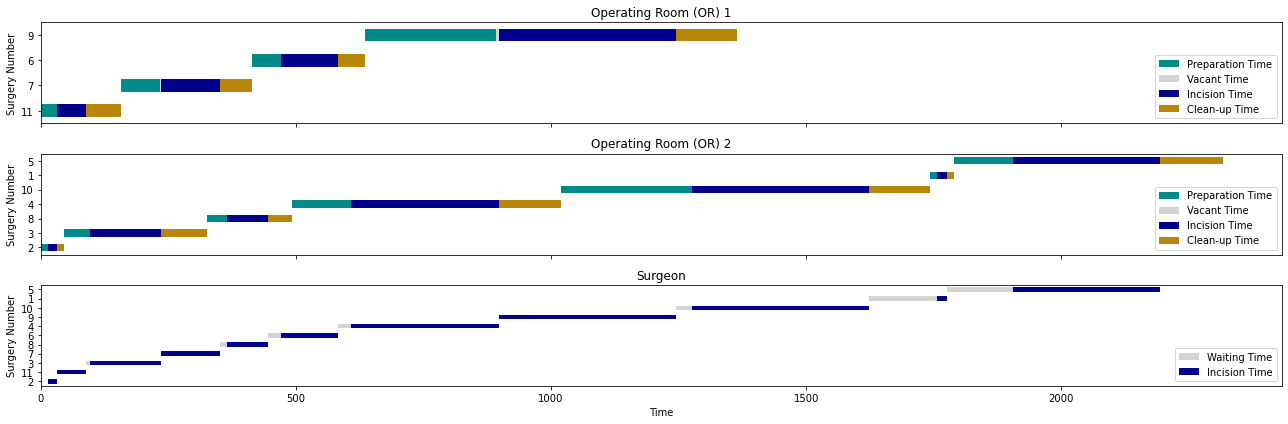

In [154]:
#Overiew of the surgery location
headers_sur_tab_wor_P4 = ["Surgery Number", "Surgery Type", "Location"]
result_sur_tab_wor_P4 = pd.DataFrame(columns = headers_sur_tab_wor_P4)
s = 1
for i in surgery:
    h = 0
    result_sur_tab_wor_P4.loc[len(result_sur_tab_wor_P4),headers_sur_tab_wor_P4[h]] = s
    s+=1
    h+=1
    result_sur_tab_wor_P4.loc[len(result_sur_tab_wor_P4)-1,headers_sur_tab_wor_P4[h]] = sur_type[i]
    h+=1
    for r in rooms:
        if W[i,r].solution_value == 1:
            result_sur_tab_wor_P4.loc[len(result_sur_tab_wor_P4)-1,headers_sur_tab_wor_P4[h]] = "OR "+ str(r)

#Overview of OR 1
result_OR1_tab_wor_P4 = result_sur_tab_wor_P4.loc[result_sur_tab_wor_P4["Location"]=="OR 1"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR1_tab_wor_P4["Surgery Number"].tolist()):
    result_OR1_tab_wor_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR1_tab_wor_P4["Surgery Number"].tolist():
    result_OR1_tab_wor_P4["Order"] = result_OR1_tab_wor_P4["Beginning of Incision Time"].rank()
result_OR1_tab_wor_P4.sort_values(by="Order", inplace = True)
result_OR1_tab_wor_P4.reset_index(drop = True, inplace = True)
result_OR1_tab_wor_P4.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR1_tab_wor_P4["Surgery Number"].tolist()):
    if idx < len(result_OR1_tab_wor_P4)-1:
        result_OR1_tab_wor_P4.loc[idx+1,"Beginning of Preparation Time"] = X[i].solution_value+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR1_tab_wor_P4["Surgery Number"].tolist()):
    result_OR1_tab_wor_P4.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR1_tab_wor_P4.loc[idx,"End of Preparation Time"] = result_OR1_tab_wor_P4.loc[idx,"Beginning of Preparation Time"]+result_OR1_tab_wor_P4.loc[idx,"Preparation Time"]
    result_OR1_tab_wor_P4.loc[idx,"Beginning of Vacant Time"] = result_OR1_tab_wor_P4.loc[idx,"End of Preparation Time"]
    result_OR1_tab_wor_P4.loc[idx,"Vacant Time"] = round(result_OR1_tab_wor_P4.loc[idx,"Beginning of Incision Time"]-result_OR1_tab_wor_P4.loc[idx,"End of Preparation Time"],3)
    result_OR1_tab_wor_P4.loc[idx,"End of Vacant Time"] = result_OR1_tab_wor_P4.loc[idx,"Beginning of Vacant Time"]+result_OR1_tab_wor_P4.loc[idx,"Vacant Time"]
    result_OR1_tab_wor_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR1_tab_wor_P4.loc[idx,"End of Incision Time"] = result_OR1_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+result_OR1_tab_wor_P4.loc[idx,"Incision Time"]
    result_OR1_tab_wor_P4.loc[idx,"Beginning of Clean-up Time"] = result_OR1_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR1_tab_wor_P4.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR1_tab_wor_P4.loc[idx,"End of Clean-up Time"] = result_OR1_tab_wor_P4.loc[idx,"Beginning of Clean-up Time"]+result_OR1_tab_wor_P4.loc[idx,"Clean-up Time"]
result_OR1_tab_wor_P4 = result_OR1_tab_wor_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time"])
result_OR1_tab_wor_P4["Unused Shift Time (if any)"] = ""
if F[1].solution_value != 0:
    result_OR1_tab_wor_P4.loc[len(result_OR1_tab_wor_P4)-1,"Unused Shift Time (if any)"] = F[1].solution_value
result_OR1_tab_wor_P4["Maximum Normal Shift Time"] = ""
result_OR1_tab_wor_P4.loc[len(result_OR1_tab_wor_P4)-1,"Maximum Normal Shift Time"] = T
result_OR1_tab_wor_P4["Overtime (if any)"] = ""
if O[1].solution_value != 0:
    result_OR1_tab_wor_P4.loc[len(result_OR1_tab_wor_P4)-1,"Overtime (if any)"] = O[1].solution_value
result_OR1_tab_wor_P4 = result_OR1_tab_wor_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of OR 2
result_OR2_tab_wor_P4 = result_sur_tab_wor_P4.loc[result_sur_tab_wor_P4["Location"]=="OR 2"].copy(deep = True).reset_index(drop = True)
for (idx, i) in enumerate(result_OR2_tab_wor_P4["Surgery Number"].tolist()):
    result_OR2_tab_wor_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_OR2_tab_wor_P4["Surgery Number"].tolist():
    result_OR2_tab_wor_P4["Order"] = result_OR2_tab_wor_P4["Beginning of Incision Time"].rank()
result_OR2_tab_wor_P4.sort_values(by="Order", inplace = True)
result_OR2_tab_wor_P4.reset_index(drop = True, inplace = True)
result_OR2_tab_wor_P4.loc[0,"Beginning of Preparation Time"] = 0
for (idx, i) in enumerate(result_OR2_tab_wor_P4["Surgery Number"].tolist()):
    if idx < len(result_OR2_tab_wor_P4)-1:
        result_OR2_tab_wor_P4.loc[idx+1,"Beginning of Preparation Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]+tc[sur_type[i]]
    else:
        break
for (idx, i) in enumerate(result_OR2_tab_wor_P4["Surgery Number"].tolist()):
    result_OR2_tab_wor_P4.loc[idx,"Preparation Time"] = tp[sur_type[i]]
    result_OR2_tab_wor_P4.loc[idx,"End of Preparation Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Preparation Time"]+result_OR2_tab_wor_P4.loc[idx,"Preparation Time"]
    result_OR2_tab_wor_P4.loc[idx,"Beginning of Vacant Time"] = result_OR2_tab_wor_P4.loc[idx,"End of Preparation Time"]
    result_OR2_tab_wor_P4.loc[idx,"Vacant Time"] = round(result_OR2_tab_wor_P4.loc[idx,"Beginning of Incision Time"]-result_OR2_tab_wor_P4.loc[idx,"End of Preparation Time"],3)
    result_OR2_tab_wor_P4.loc[idx,"End of Vacant Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Vacant Time"]+result_OR2_tab_wor_P4.loc[idx,"Vacant Time"]
    result_OR2_tab_wor_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_OR2_tab_wor_P4.loc[idx,"End of Incision Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+result_OR2_tab_wor_P4.loc[idx,"Incision Time"]
    result_OR2_tab_wor_P4.loc[idx,"Beginning of Clean-up Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    result_OR2_tab_wor_P4.loc[idx,"Clean-up Time"] = tc[sur_type[i]]
    result_OR2_tab_wor_P4.loc[idx,"End of Clean-up Time"] = result_OR2_tab_wor_P4.loc[idx,"Beginning of Clean-up Time"]+result_OR2_tab_wor_P4.loc[idx,"Clean-up Time"]
result_OR2_tab_wor_P4["Unused Shift Time (if any)"] = ""
if F[2].solution_value != 0:
    result_OR2_tab_wor_P4.loc[len(result_OR2_tab_wor_P4)-1,"Unused Shift Time (if any)"] = F[2].solution_value
result_OR2_tab_wor_P4["Maximum Normal Shift Time"] = ""
result_OR2_tab_wor_P4.loc[len(result_OR2_tab_wor_P4)-1,"Maximum Normal Shift Time"] = T
result_OR2_tab_wor_P4["Overtime (if any)"] = ""
if O[2].solution_value != 0:
    result_OR2_tab_wor_P4.loc[len(result_OR2_tab_wor_P4)-1,"Overtime (if any)"] = O[2].solution_value
result_OR2_tab_wor_P4 = result_OR2_tab_wor_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Beginning of Preparation Time", "Preparation Time", "End of Preparation Time", "Beginning of Vacant Time", "Vacant Time", "End of Vacant Time",
                                                         "Beginning of Incision Time", "Incision Time", "End of Incision Time", "Beginning of Clean-up Time", "Clean-up Time", "End of Clean-up Time", "Unused Shift Time (if any)", "Maximum Normal Shift Time", "Overtime (if any)"])

#Overview of the surgeon
result_surgeons_tab_wor_P4 = result_sur_tab_wor_P4.copy(deep = True)
for (idx, i) in enumerate(result_surgeons_tab_wor_P4["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P4.loc[idx,"Beginning of Incision Time"] = X[i].solution_value
for i in result_surgeons_tab_wor_P4["Surgery Number"].tolist():
    result_surgeons_tab_wor_P4["Order"] = result_surgeons_tab_wor_P4["Beginning of Incision Time"].rank()
result_surgeons_tab_wor_P4.sort_values(by="Order", inplace = True)
result_surgeons_tab_wor_P4.reset_index(drop = True, inplace = True)
result_surgeons_tab_wor_P4["Start Time of Surgeon"] = 0
result_surgeons_tab_wor_P4.loc[0,"Start Time of Surgeon"] = S.solution_value
result_surgeons_tab_wor_P4.loc[0,"Beginning of Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P4["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P4)-1:
        result_surgeons_tab_wor_P4.loc[idx+1,"Beginning of Waiting Time"] = result_surgeons_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+ts[sur_type[i]]
    else:
        break
result_surgeons_tab_wor_P4.loc[0,"Waiting Time"] = 0
for (idx, i) in enumerate(result_surgeons_tab_wor_P4["Surgery Number"].tolist()):
    if idx < len(result_surgeons_tab_wor_P4)-1:
        result_surgeons_tab_wor_P4.loc[idx+1,"Waiting Time"] = round(result_surgeons_tab_wor_P4.loc[idx+1,"Beginning of Incision Time"]-result_surgeons_tab_wor_P4.loc[idx+1,"Beginning of Waiting Time"],3)
    else:
        break
for (idx, i) in enumerate(result_surgeons_tab_wor_P4["Surgery Number"].tolist()):
    result_surgeons_tab_wor_P4.loc[idx,"End of Waiting Time"] = result_surgeons_tab_wor_P4.loc[idx,"Beginning of Waiting Time"]+result_surgeons_tab_wor_P4.loc[idx,"Waiting Time"]
    result_surgeons_tab_wor_P4.loc[idx,"Incision Time"] = ts[sur_type[i]]
    result_surgeons_tab_wor_P4.loc[idx,"End of Incision Time"] = result_surgeons_tab_wor_P4.loc[idx,"Beginning of Incision Time"]+result_surgeons_tab_wor_P4.loc[idx,"Incision Time"]
result_surgeons_tab_wor_P4 = result_surgeons_tab_wor_P4.reindex(columns = ["Surgery Number", "Surgery Type", "Order", "Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "End of Waiting Time", "Beginning of Incision Time", "Incision Time", "End of Incision Time"])

#Reindex the surgery number as index
result_sur_tab_wor_P4 = result_sur_tab_wor_P4.set_index("Surgery Number").rename_axis("Surgery Number")
result_OR1_tab_wor_P4 = result_OR1_tab_wor_P4.set_index("Surgery Number").rename_axis("Surgery Number | OR 1")
result_OR2_tab_wor_P4 = result_OR2_tab_wor_P4.set_index("Surgery Number").rename_axis("Surgery Number | OR 2")
result_surgeons_tab_wor_P4 = result_surgeons_tab_wor_P4.set_index("Surgery Number").rename_axis("Surgery Number")

#Overview of cost
headers_cost_tab_wor_P4 = headers_cost_tab_wor_P4 = ["OR staff in OR 1 Overtime (in min)", "OR staff in OR 2 Overtime (in min)", "Total OR staff in OR Overtime (in min)", "Cost per min of OR staff Overtime", "Total OR staff in OR Overtime Cost", "OR 1 Vacant Time (in min)", "OR 2 Vacant Time (in min)", "Total OR Vacant Time (in min)", "Cost per min of OR Vacant Time", "Total OR Vacant Time Cost", "Surgeon Waiting Time (in min)", "Cost per min of Surgeon Waiting Time", "Total OR Surgeon Waiting Time Cost", "Total Cost"]
result_cost_tab_wor_P4 = pd.DataFrame(columns = headers_cost_tab_wor_P4)
h=0
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4), headers_cost_tab_wor_P4[h]] = O[1].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = O[2].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = O[1].solution_value+O[2].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = co/60
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = (O[1].solution_value+O[2].solution_value)*(co/60)
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = VT[1].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = VT[2].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = VT[1].solution_value+VT[2].solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = cv/60
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = (VT[1].solution_value+VT[2].solution_value)*(cv/60)
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = WT.solution_value
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = cw/60
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = WT.solution_value*(cw/60)
h+=1
result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, headers_cost_tab_wor_P4[h]] = result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, "Total OR staff in OR Overtime Cost"]+result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, "Total OR Vacant Time Cost"]+result_cost_tab_wor_P4.loc[len(result_cost_tab_wor_P4)-1, "Total OR Surgeon Waiting Time Cost"]

##Timeline
import warnings
warnings.filterwarnings("ignore", module = "matplotlib.*")
figure_wor_P4, (result_OR1_plot_wor_P4, result_OR2_plot_wor_P4, result_surgeons_plot_wor_P4) = plt.subplots(nrows=3, ncols=1, sharex = True)

#OR 1
result_OR1_plot_wor_P4 = result_OR1_tab_wor_P4.plot.barh(ax = result_OR1_plot_wor_P4, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 1", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR1_plot_wor_P4.set_xlabel("Time")
result_OR1_plot_wor_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR1_plot_wor_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#OR 2
result_OR2_plot_wor_P4 = result_OR2_tab_wor_P4.plot.barh(ax = result_OR2_plot_wor_P4, y = ["Beginning of Preparation Time", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], stacked = True, title = "Operating Room (OR) 2", color = ["white", "darkcyan", "lightgrey", "darkblue", "darkgoldenrod"], figsize = (18,6))
result_OR2_plot_wor_P4.set_xlabel("Time")
result_OR2_plot_wor_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_OR2_plot_wor_P4.legend(["_Hidden", "Preparation Time", "Vacant Time", "Incision Time", "Clean-up Time"], loc="lower right")
plt.show

#Surgeon
result_surgeons_plot_wor_P4 = result_surgeons_tab_wor_P4.plot.barh(ax = result_surgeons_plot_wor_P4, y = ["Start Time of Surgeon", "Beginning of Waiting Time", "Waiting Time", "Incision Time"], stacked = True, title = "Surgeon", color = ["white","white","lightgrey", "darkblue"], figsize = (18,6))
result_surgeons_plot_wor_P4.set_xlabel("Time")
result_surgeons_plot_wor_P4.set_ylabel("Surgery Number")
plt.xticks(rotation = "horizontal")
result_surgeons_plot_wor_P4.legend(["_Hidden", "_Hidden", "Waiting Time", "Incision Time"], loc="lower right")
plt.show

plt.tight_layout()

In [155]:
print(result_sur_tab_wor_P4)
print(result_OR1_tab_wor_P4)
print(result_OR2_tab_wor_P4)
print(result_surgeons_tab_wor_P4)
print(result_cost_tab_wor_P4)

               Surgery Type Location
Surgery Number                      
1                         A     OR 2
2                         A     OR 2
3                         C     OR 2
4                         E     OR 2
5                         E     OR 2
6                         F     OR 1
7                         G     OR 1
8                         H     OR 2
9                         I     OR 1
10                        I     OR 2
11                        J     OR 1
                      Surgery Type  Order  Beginning of Preparation Time  \
Surgery Number | OR 1                                                      
11                               J    1.0                            0.0   
7                                G    2.0                          156.1   
6                                F    3.0                          413.4   
9                                I    4.0                          634.7   

                       Preparation Time  End of Preparation Ti

##### Export the results

In [156]:
with pd.ExcelWriter("SurgeryScheduling_Worst_P4.xlsx") as writer:
    result_sur_tab_wor_P4.to_excel(writer, sheet_name = "Surgery Location")
    result_OR1_tab_wor_P4.to_excel(writer, sheet_name = "OR 1")
    result_OR2_tab_wor_P4.to_excel(writer, sheet_name = "OR 2")
    result_surgeons_tab_wor_P4.to_excel(writer, sheet_name = "Surgeon")
    result_cost_tab_wor_P4.to_excel(writer, sheet_name = "Cost")   

In [157]:
figure_wor_P4.savefig("Timeline_Worst_P4.pdf", bbox_inches="tight")
figure_wor_P4.savefig("Timeline_Worst_P4.png", bbox_inches="tight")

#### Problem Instance 4 (Comparison of Scenarios Case, Mean Case and Worst Case)

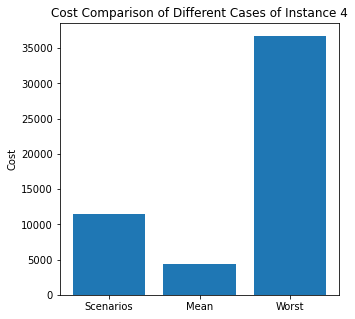

In [158]:
#Objective value comparison
x_comp_P4 = ["Scenarios", "Mean", "Worst"]
y_comp_P4 = [model_stoc_P4.objective_value, model_P4.objective_value, model_wor_P4.objective_value]
cost_plot_comp_P4 = plt.figure(figsize = (5,5))
plt.bar(x_comp_P4, y_comp_P4)
plt.ylabel("Cost")
plt.title("Cost Comparison of Different Cases of Instance 4")

#Location and sequence comparison
result_OR1_tab_P4["Location"] = "OR 1"
result_OR1_tab_P4 = result_OR1_tab_P4.reset_index()
result_OR1_tab_P4.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_P4["Location"] = "OR 2"
result_OR2_tab_P4 = result_OR2_tab_P4.reset_index()
result_OR2_tab_P4.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_mean_P4 = pd.concat([result_OR1_tab_P4, result_OR2_tab_P4])
result_all_tab_mean_P4.rename(columns = {"Surgery Number":"Surgery Number | Mean Case"}, inplace = True)
result_all_tab_mean_P4 = result_all_tab_mean_P4.reindex(columns = ["Surgery Number | Mean Case","Surgery Type","Location","Order"])
result_all_tab_mean_P4 = result_all_tab_mean_P4.reset_index(drop = True)

result_OR1_tab_wor_P4["Location"] = "OR 1"
result_OR1_tab_wor_P4 = result_OR1_tab_wor_P4.reset_index()
result_OR1_tab_wor_P4.rename(columns = {"Surgery Number | OR 1":"Surgery Number"}, inplace = True)
result_OR2_tab_wor_P4["Location"] = "OR 2"
result_OR2_tab_wor_P4 = result_OR2_tab_wor_P4.reset_index()
result_OR2_tab_wor_P4.rename(columns = {"Surgery Number | OR 2":"Surgery Number"}, inplace = True)
result_all_tab_wor_P4 = pd.concat([result_OR1_tab_wor_P4, result_OR2_tab_wor_P4])
result_all_tab_wor_P4.rename(columns = {"Surgery Number":"Surgery Number | Worst Case"}, inplace = True)
result_all_tab_wor_P4 = result_all_tab_wor_P4.reindex(columns = ["Surgery Number | Worst Case","Surgery Type","Location","Order"])
result_all_tab_wor_P4 = result_all_tab_wor_P4.reset_index(drop = True)

result_sur_tab_stoc_P4 = result_sur_tab_stoc_P4.reset_index()
result_sur_tab_stoc_P4.rename(columns = {"Surgery Number":"Surgery Number | Scenarios Case"}, inplace = True)

result_all_sur_tab_stoc_P4 = pd.concat([result_sur_tab_stoc_P4,result_all_tab_mean_P4,result_all_tab_wor_P4], axis = 1)


##### Export the results

In [159]:
with pd.ExcelWriter("SurgeryScheduling_Comp_P4.xlsx") as writer:
    result_all_sur_tab_stoc_P4.to_excel(writer, sheet_name = "Cases Comparison_P4")

cost_plot_comp_P4.savefig("CostComparison_P4.pdf", bbox_inches="tight")
cost_plot_comp_P4.savefig("CostComparison_P4.png", bbox_inches="tight")